# Attention-based Speech Recognition

<img src="https://cdn.shopify.com/s/files/1/0272/2080/3722/products/SmileBumperSticker_5400x.jpg" alt="A cute cat" width="600">

[Speech Transformer Paper](https://ieeexplore.ieee.org/document/8462506)<br>

[Attention Is All You Need Paper](https://arxiv.org/pdf/1706.03762.pdf)<br>

# Libraries

In [ ]:
!nvidia-smi

Sun Apr 28 17:33:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
''' Installing some required libraries. '''
!pip install python-levenshtein torchsummaryX wandb kaggle pytorch-nlp --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 981.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.1 MB/s eta 0:00:00


##  Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as tat

from torchsummaryX import summary
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import gc
import os
import math
import yaml
import random
import zipfile
import datetime

import glob
import wandb
import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

''' Imports for decoding and distance calculation. '''
import Levenshtein

import warnings
warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

Device:  cuda


# Configurations

In [ ]:
%%writefile config.yaml

###### Dataset -----------------------------------------------------------------
train_dataset   : "train-clean-100"     # train-clean-50 (primarily for debugging purposes), train-clean-100
cepstral_norm   : True
input_dim       : 27
batch_size      : 64                    # decrease this as you modify the network architecture

###### Encoder Parameters ------------------------------------------
## Universal (Part I and II)
enc_dropout     : 0.2                   # [0.1, 0.4]
## Transformer-related (Part II)
enc_num_layers  : 1                     # [1, 3]
enc_num_heads   : 1                     # [1, 4]

###### Decoder Parameters ------------------------------------------
## Transformer-related (Part I and II)
dec_dropout     : 0.2                   # [0.1, 0.4]
dec_num_layers  : 2                     # [1, 3]
dec_num_heads   : 2                     # [1, 4]

###### Network Parameters ------------------------------------------------------
d_model         : 512                   # [256, 1024]
d_ff            : 2048                  # [512, 4096]

###### Learning Rate ---------------------------------------------------------------
learning_rate   : 1E-4                  # [1E-3, 1E-4], this will depend on the specified optimizer

###### Optimizer ---------------------------------------------------------------
optimizer       : "AdamW"               # Adam, AdamW

## if SGD
momentum        : 0.0
nesterov        : True

###### Scheduler ---------------------------------------------------------------
scheduler       : "ReduceLR"     # CosineAnnealing, ReduceLR

## if ReduceLR

## patience less than validation frquency can mean learning rate always dropping after patience epochs
## specify a suitable threshold too
factor          : 0.9
patience        : 5

###### Training Parameters -----------------------------------------------------
epochs          : 150

###### Name --------------------------------------------------------------------
Name: ""                              

Writing config.yaml


In [ ]:
with open("config.yaml") as file:
    config = yaml.safe_load(file)

In [ ]:
config
# {'train_dataset': 'train-clean-100',
#  'cepstral_norm': True,
#  'input_dim': 27,
#  'batch_size': 64,
#  'enc_dropout': 0.2,
#  'enc_num_layers': 1,
#  'enc_num_heads': 1,
#  'dec_dropout': 0.2,
#  'dec_num_layers': 2,
#  'dec_num_heads': 2,
#  'd_model': 512,
#  'd_ff': 2048,
#  'learning_rate': '1E-4',
#  'optimizer': 'AdamW',
#  'momentum': 0.0,
#  'nesterov': True,
#  'scheduler': 'ReduceLR',
#  'factor': 0.9,
#  'patience': 5,
#  'epochs': 150,
#  'Name': 'S'}

# Kaggle Dataset Download

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:

    # Enter your kaggle username <USERNAME> and key <KEY> here.
    f.write('{"username":"","key":""}')

!chmod 600 /root/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 978.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73249 sha256=75d70f0f241817b77410ea78267fa5533ede0ff0114faa836c79a6d706862f49
  Stored in directory: /root/.cache/pip/wheels/0b/76/ca/e58f8afa83166a0e68f0d5cd2e7f99d260bdc40e35da080eee
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16


In [ ]:
''' Downloading the dataset. '''
!kaggle competitions download -c automatic-speech-recognition-s24

''' Unzipping quickly and quietly. '''
!unzip -q automatic-speech-recognition-s24.zip -d ./data

100% 5.44G/5.46G [00:30<00:00, 279MB/s]
100% 5.46G/5.46G [00:30<00:00, 191MB/s]


# Character-based LibriSpeech Dataset

In [ ]:
VOCAB = [
    "<pad>", "<sos>", "<eos>",
    "A",   "B",    "C",    "D",
    "E",   "F",    "G",    "H",
    "I",   "J",    "K",    "L",
    "M",   "N",    "O",    "P",
    "Q",   "R",    "S",    "T",
    "U",   "V",    "W",    "X",
    "Y",   "Z",    "'",    " ",
]

VOCAB_MAP = {VOCAB[i]:i for i in range(0, len(VOCAB))}

PAD_TOKEN = VOCAB_MAP["<pad>"]
SOS_TOKEN = VOCAB_MAP["<sos>"]
EOS_TOKEN = VOCAB_MAP["<eos>"]

print(f"Length of Vocabulary    : {len(VOCAB)}")
print(f"VOCAB                   : {VOCAB}")
print(f"PAD_TOKEN               : {PAD_TOKEN}")
print(f"SOS_TOKEN               : {SOS_TOKEN}")
print(f"EOS_TOKEN               : {EOS_TOKEN}")

Length of Vocabulary    : 31
VOCAB                   : ['<pad>', '<sos>', '<eos>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", ' ']
PAD_TOKEN               : 0
SOS_TOKEN               : 1
EOS_TOKEN               : 2


## Dataset

In [ ]:
class SpeechDataset(torch.utils.data.Dataset):
    ''' memory inefficient : loading data in __init__ for simplicty

        You may decide to load data in __getitem__ if you wish.
        However, doing this memory inefficiently makes __init__ function takes
        the load of loading the data, and shifts it away from during the training process.
    '''

    def __init__(self, root_dir, partition, cepstral=True):

        self.mfcc_dir           = f"{root_dir}/{partition}*/mfcc/*"
        self.transcript_dir     = f"{root_dir}/{partition}*/transcripts/*"

        self.mfcc_files         = sorted(glob.glob(self.mfcc_dir))
        self.transcript_files   = sorted(glob.glob(self.transcript_dir))

        assert len(self.mfcc_files) == len(self.transcript_files)

        self.mfcc_files         = self.mfcc_files
        self.transcript_files   = self.transcript_files
        self.length             = len(self.transcript_files)
        self.vocab              = VOCAB

        print("Loaded Path: ", partition)

        self.mfccs, self.transcripts_shifted, self.transcripts_golden  = [], [], []
        for file in self.mfcc_files:
            mfcc = np.load(file)

            if cepstral:
                mfcc = (mfcc - np.mean(mfcc, axis=0)) / (np.std(mfcc, axis=0) + 1E-8)
            self.mfccs.append(mfcc)

        for file in self.transcript_files:
            temp = np.load(file)[1:-1]

            self.transcripts_shifted.append(np.array([SOS_TOKEN] + [self.vocab.index(i) for i in temp]))
            self.transcripts_golden.append(np.array([self.vocab.index(i) for i in temp] + [EOS_TOKEN]))

        assert len(self.mfccs) == len(self.transcripts_shifted)


    def __len__(self): return self.length


    def __getitem__(self, ind):
        mfcc                = torch.FloatTensor(self.mfccs[ind])
        shifted_transcript  = torch.tensor(self.transcripts_shifted[ind])
        golden_transcript   = torch.tensor(self.transcripts_golden[ind])

        return mfcc, shifted_transcript, golden_transcript


    def collate_fn(self, batch):
        # @NOTE: batch corresponds to output from __getitem__ for a minibatch

        '''
        1.  Extract the features and labels from 'batch'.
        2.  We will additionally need to pad both features and labels,
            look at PyTorch's documentation for pad_sequence.
        3.  This is a good place to perform transforms, if you so wish.
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lengths of features, and lengths of labels.

        '''

        # Batch of input mfcc coefficients.
        batch_mfcc              = [i[0] for i in batch]

        # Batch of output characters (shifted and golden).
        batch_transcript        = [i[1] for i in batch]
        batch_golden            = [i[2] for i in batch]

        lengths_mfcc            = [len(i) for i in batch_mfcc]
        lengths_transcript      = [len(i) for i in batch_transcript]

        # Also be sure to check the input format (batch_first).
        batch_mfcc_pad          = pad_sequence(batch_mfcc, batch_first=True, padding_value=PAD_TOKEN)
        batch_transcript_pad    = pad_sequence(batch_transcript, batch_first=True, padding_value=PAD_TOKEN)
        batch_golden_pad        = pad_sequence(batch_golden, batch_first=True, padding_value=PAD_TOKEN)


        # You may apply some transformations, Time and Frequency masking, here in the collate function:
        # Food for Thought -> Why are we applying the transformation here and not in the __getitem__?
        #                  -> Would we apply transformation on the validation set as well?
        #                  -> Is the order of axes / dimensions as expected for the transform functions?


        # Return the following values:
        # padded features, padded shifted labels, padded golden labels, actual length of features, actual length of the shifted labels
        return batch_mfcc_pad, batch_transcript_pad, batch_golden_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)

In [ ]:
class SpeechTestDataset(torch.utils.data.Dataset):

    def __init__(self, root_dir, partition, cepstral=True):

        self.mfcc_dir       = f"{root_dir}/{partition}*/mfcc/*"
        self.mfcc_files     = sorted(glob.glob(self.mfcc_dir))
        self.length         = len(self.mfcc_files)

        self.mfccs = []
        for file in self.mfcc_files:
            mfcc = np.load(file)
            if cepstral: mfcc = (mfcc - np.mean(mfcc, axis=0)) / (np.std(mfcc, axis=0) + 1E-8)
            self.mfccs.append(mfcc)

        print("Loaded Path: ", partition)


    def __len__(self): return self.length


    def __getitem__(self, ind):
        mfcc = self.mfccs[ind]

        return torch.FloatTensor(mfcc)


    def collate_fn(self, batch):
        # @NOTE: batch corresponds to output from __getitem__ for a minibatch

        '''
        TODO:
        1.  Extract the features and labels from 'batch'.
        2.  We will additionally need to pad the features,
            look at PyTorch's documentation for pad_sequence.
        3.  Return batch of features, lengths of features.

        '''

        batch_mfcc      = batch
        batch_mfcc_pad  = pad_sequence(batch_mfcc, batch_first=True)
        lengths_mfcc    = [len(i) for i in batch_mfcc]

        return batch_mfcc_pad, torch.tensor(lengths_mfcc)

In [ ]:
# @NOTE: use the config file to specify PARTITION and CEPSTRAL
DATA_DIR        = '/content/data/'              # Enter your data directory here.
PARTITION       = 'train-clean-100'             # Enter your training directory here.
CEPSTRAL        = True                          # Enter your cepstral_norm parameter here.

train_dataset   = SpeechDataset(
    root_dir    = DATA_DIR,
    partition   = PARTITION,
    cepstral    = CEPSTRAL
)

val_dataset     = SpeechDataset(
    root_dir    = DATA_DIR,
    partition   = "dev-clean",
    cepstral    = CEPSTRAL
)

test_dataset    = SpeechTestDataset(
    root_dir    = DATA_DIR,
    partition   = "test-clean",
    cepstral    = CEPSTRAL,
)

gc.collect()

Loaded Path:  train-clean-100
Loaded Path:  dev-clean
Loaded Path:  test-clean


580

## DataLoader

In [ ]:
train_loader    = torch.utils.data.DataLoader(
    dataset     = train_dataset,
    batch_size  = config["batch_size"],
    shuffle     = True,
    num_workers = 4,
    pin_memory  = True,
    collate_fn  = train_dataset.collate_fn
)

val_loader      = torch.utils.data.DataLoader(
    dataset     = val_dataset,
    batch_size  = config["batch_size"],
    shuffle     = False,
    num_workers = 2,
    pin_memory  = True,
    collate_fn  = val_dataset.collate_fn,
)

test_loader     = torch.utils.data.DataLoader(
    dataset     = test_dataset,
    batch_size  = config["batch_size"],
    shuffle     = False,
    num_workers = 2,
    pin_memory  = True,
    collate_fn  = test_dataset.collate_fn,
)

print("No. of Train MFCCs   : ", train_dataset.__len__())
print("Batch Size           : ", config["batch_size"])
print("Train Vatches        : ", train_loader.__len__())
print("Val Batches          : ", val_loader.__len__())
print("Test Batches         : ", test_loader.__len__())

No. of Train MFCCs   :  28539
Batch Size           :  64
Train Vatches        :  446
Val Batches          :  43
Test Batches         :  41


In [ ]:
''' Sanity Check '''

print("Checking the Shapes of the Data --\n")

for batch in train_loader:
    x_pad, y_shifted_pad, y_golden_pad, x_len, y_len, = batch

    print(f"x_pad shape:\t\t{x_pad.shape}")
    print(f"x_len shape:\t\t{x_len.shape}\n")

    print(f"y_shifted_pad shape:\t{y_shifted_pad.shape}")
    print(f"y_golden_pad shape:\t{y_golden_pad.shape}")
    print(f"y_len shape:\t\t{y_len.shape}\n")

    # print(y_shifted_pad)

    break

Checking the Shapes of the Data --

x_pad shape:		torch.Size([64, 1636, 27])
x_len shape:		torch.Size([64])

y_shifted_pad shape:	torch.Size([64, 292])
y_golden_pad shape:	torch.Size([64, 292])
y_len shape:		torch.Size([64])



## DataLoader Verification

- Train Dataset (train-clean-50)
```
Loaded Path:  train-clean-50
Max MFCC Length          :  1982
Avg MFCC Length          :  1256.06069100848
Max Transcript Length    :  354
Max Transcript Length    :  182.2676431424767
```

- Train Dataset (train-clean-100)
```
Loaded Path:  train-clean-100
Max MFCC Length          :  2448
Avg MFCC Length          :  1264.6258453344547
Max Transcript Length    :  399
Max Transcript Length    :  186.65321139493324
```

- Validation Dataset
```
Loaded Path:  dev-clean
Max MFCC Length          :  3260
Avg MFCC Length          :  713.3570107288198
Max Transcript Length    :  517
Max Transcript Length    :  107.71698113207547
```

- Test Dataset
```
Loaded Path:  test-clean
Max MFCC Length          :  27
Avg MFCC Length          :  27.0
```

- Population Stats
```
Max Length:  3260
```

If your values is not matching, read hints and think what could have gone wrong. Then approach TAs.



In [ ]:
def verify_dataset(dataset, partition="train-clean-100"):
    print("Loaded Path: ", partition)

    if partition != "test-clean":
        print("Max MFCC Length          : ", np.max([data[0].shape[0] for data in dataset]))
        print("Avg MFCC Length          : ", np.mean([data[0].shape[0] for data in dataset]))
        print("Max Transcript Length    : ", np.max([data[1].shape[0] for data in dataset]))
        print("Max Transcript Length    : ", np.mean([data[1].shape[0] for data in dataset]))
    else:
        print("Max MFCC Length          : ", np.max([data[0].shape[0] for data in dataset]))
        print("Avg MFCC Length          : ", np.mean([data[0].shape[0] for data in dataset]))

    print()

verify_dataset(train_dataset, partition="train-clean-100")
verify_dataset(val_dataset, partition="dev-clean")
verify_dataset(test_dataset, partition="test-clean")

dataset_max_len = max(
    np.max([data[0].shape[0] for data in train_dataset]),
    np.max([data[0].shape[0] for data in val_dataset]),
    np.max([data[0].shape[0] for data in test_dataset]),
)

print("Max Length: ", dataset_max_len)

Loaded Path:  train-clean-100
Max MFCC Length          :  2448
Avg MFCC Length          :  1264.6258453344547
Max Transcript Length    :  399
Max Transcript Length    :  185.65321139493324

Loaded Path:  dev-clean
Max MFCC Length          :  3260
Avg MFCC Length          :  713.3570107288198
Max Transcript Length    :  517
Max Transcript Length    :  107.71698113207547

Loaded Path:  test-clean
Max MFCC Length          :  27
Avg MFCC Length          :  27.0

Max Length:  3260


# Introduction

Transformers are highly effective for speech recognition tasks because they utilize self-attention mechanisms, enabling them to analyze entire sequences of audio data in one shot. This allows for a nuanced understanding of long-range dependencies and the complex temporal dynamics inherent in speech. Compared to traditional models, transformers offer improved accuracy and efficiency, adeptly handling variations in speech patterns, accents, and intonations; thus, making them exceptionally suitable for advanced speech recognition applications.

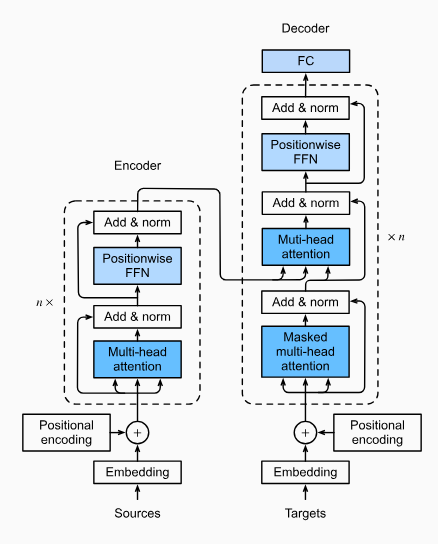

Given the complicated nature of these models, training in this homework will be a little different from other homeworks.<br>
We will employ the following to effectively train the transformer with fewer resources (data and compute power).
<br>
* **Data Complexity and Model Capacity**:  Starting with a CNN-LSTM for input sequences captures temporal dynamics and dependencies early on, simplifying initial learning. This is effective for data with strong temporal or sequential patterns, which LSTMs excel at handling. We will use an already trained model (trained in HW3P2).


* **Gradual (Incremental) Learning**: Starting with a simpler model (like an LSTM) allows the neural network to first learn the basic structures and patterns in the data. When we later introduce more complex mechanisms (like a transformer encoder), the model already has a foundational understanding of the data. This foundation can lead to a smoother and more effective learning process when the complexity of the model increases. In other words, we are using a simple, pretrained LSTM encoder as the basis for our transformer decoder and incrementally adding complexity!

* **Learning Efficiency**: By freezing certain parts of the model during different stages of training, we focus the learning capacity of the network on specific modules, making the training process more efficient. This stepwise unfreezing and training allows different components of the model to adapt gradually, which can be very useful when integrating parts of the model that learn at different rates.

* **Adaptation to Data Characteristics**: This strategy implicitly takes advantage of the data's characteristics by adjusting the model's architecture and training procedure to better suit the data's structure. For instance, if the data contains intricate sequential patterns, starting with an LSTM can harness these patterns effectively. Then, by introducing a transformer encoder, the model can further learn to capture complex, long-range dependencies within the data, something transformers are exceptionally good at.


## Utilities

To make make building the transformer easy, we will define various utility functions and classes which corresponds to the various modules of the transformer. All Components are provided for you but your task will be too understand the modules as you will need  them in answering Canvas quizzes as well as implementing other parts of this notebook. Please refer to the write-up for more information.

In [ ]:
def create_mask_1(padded_input, input_lengths=None, pad_idx=None):
    """ Create a mask to identify non-padding positions.

    Args:
        padded_input: The input tensor with padding, shape (N, T, ...) or (N, T).
        input_lengths: Optional, the actual lengths of each sequence before padding, shape (N,).
        pad_idx: Optional, the index used for padding tokens.

    Returns:
        A mask tensor with shape (N, T, 1), where non-padding positions are marked with 1 and padding positions are marked with 0.
    """

    assert input_lengths is not None or pad_idx is not None

    # Create a mask based on input_lengths
    if input_lengths is not None:
        N = padded_input.size(0)        # padded_input : (N x T x ...)
        non_pad_mask = padded_input.new_ones(padded_input.size()[:-1])  # (N x T)

        # Set the mask to 0 for padding positions
        for i in range(N):
          non_pad_mask[i, input_lengths[i]:] = 0

    if pad_idx is not None:             # padded_input : N x T

        assert padded_input.dim() == 2

        # Create a mask where non-padding positions are marked with 1 and padding positions are marked with 0
        non_pad_mask = padded_input.ne(pad_idx).float()

    return non_pad_mask.unsqueeze(-1)   # unsqueeze(-1) for broadcasting

In [ ]:
def create_mask_2(seq, pad_idx=None):
    """ Create a mask to prevent positions from attending to subsequent positions.

    Args:
        seq: The input sequence tensor, shape (batch_size, sequence_length).

    Returns:
        A mask tensor with shape (batch_size, sequence_length, sequence_length),
            where positions are allowed to attend to previous positions but not to subsequent positions.
    """

    sz_b, len_s = seq.size()

    # Create an upper triangular matrix with zeros on the diagonal and below (indicating allowed positions)
    #   and ones above the diagonal (indicating disallowed positions)
    subsequent_mask = torch.triu(
        torch.ones((len_s, len_s), device=seq.device, dtype=torch.uint8), diagonal=1)

    # Expand the mask to match the batch size, resulting in a mask for each sequence in the batch.
    mask = subsequent_mask.unsqueeze(0).expand(sz_b, -1, -1)  # b x ls x ls


    ''' Create a mask to ignore padding positions in the key sequence during attention calculation. '''

    # Expanding to fit the shape of key query attention matrix.
    if pad_idx != None:
      len_q = seq.size(1)

      # Create a mask where padding positions in the key sequence are marked with 1.
      padding_mask  = seq.eq(pad_idx)

      # Expand the mask to match the dimensions of the key-query attention matrix.
      padding_mask  = padding_mask.unsqueeze(1).expand(-1, len_q, -1)  # b x lq x lk
      mask          = (padding_mask + mask).gt(0)

    else:
      mask = mask.gt(0)

    return mask

In [ ]:
def create_mask_3(padded_input, input_lengths, expand_length):
    """ Create an attention mask to ignore padding positions in the input sequence during attention calculation.

    Args:
        padded_input: The input tensor with padding, shape (N, Ti, ...).
        input_lengths: The actual lengths of each sequence before padding, shape (N,).
        expand_length: The length to which the attention mask should be expanded,
            usually equal to the length of the sequence that the attention scores will be applied to.

    Returns:
        An attention mask tensor with shape (N, expand_length, Ti),
            where padding positions in the input sequence are marked with 1 and other positions are marked with 0.
    """

    # Create a mask to identify non-padding positions, shape (N, Ti, 1)
    # (N x Ti x 1)
    non_pad_mask    = create_mask_1(padded_input, input_lengths=input_lengths)

    # Invert the mask to identify padding positions, shape (N, Ti)
    # N x Ti, lt(1) like-not operation
    pad_mask        = non_pad_mask.squeeze(-1).lt(1)


    # Expand the mask to match the dimensions of the attention matrix, shape (N, expand_length, Ti)
    attn_mask       = pad_mask.unsqueeze(1).expand(-1, expand_length, -1)

    return attn_mask

In [ ]:
class ScaledDotProductAttention(torch.nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature    = temperature                       # Scaling factor for the dot product
        self.dropout        = torch.nn.Dropout(attn_dropout)    # Dropout layer for attention weights
        self.softmax        = torch.nn.Softmax(dim=2)           # Softmax layer along the attention dimension

    def forward(self, q, k, v, mask=None):

        # Calculate the dot product between queries and keys.
        attn = torch.bmm(q, k.transpose(1, 2))

        # Scale the dot product by the temperature.
        attn = attn / self.temperature

        if mask is not None:
            # Apply the mask by setting masked positions to a large negative value.
            # This ensures they have a softmax score close to zero.
            mask_value = -1e+30 if attn.dtype == torch.float32 else -1e+4
            attn = attn.masked_fill(mask, mask_value)

        # Apply softmax to obtain attention weights.
        attn    = self.softmax(attn)

        # Apply dropout to the attention weights.
        attn    = self.dropout(attn)

        # Compute the weighted sum of values based on the attention weights.
        output  = torch.bmm(attn, v)

        return output, attn # Return the attention output and the attention weights.

In [ ]:
def save_attention_plot(attention_weights, epoch=0):
    ''' function for saving attention weights plot to a file

        @NOTE: default starter code set to save cross attention
    '''

    plt.clf()  # Clear the current figure
    sns.heatmap(attention_weights, cmap="GnBu")  # Create heatmap

    # Save the plot to a file. Specify the directory if needed.
    plt.savefig(f"cross_attention-epoch{epoch}.png")

In [ ]:
class MultiHeadAttention(torch.nn.Module):
    ''' Multi-Head Attention Module '''

    def __init__(self, n_head, d_model, dropout=0.1):
        super().__init__()

        self.n_head = n_head # Number of attention heads
        self.d_k    = d_model // n_head
        self.d_v    = d_model // n_head


        # Linear layers for projecting the input query, key, and value to multiple heads
        self.w_qs   = torch.nn.Linear(d_model, n_head * self.d_k)
        self.w_ks   = torch.nn.Linear(d_model, n_head * self.d_k)
        self.w_vs   = torch.nn.Linear(d_model, n_head * self.d_v)

        torch.nn.init.normal_(self.w_qs.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_k)))
        torch.nn.init.normal_(self.w_ks.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_k)))
        torch.nn.init.normal_(self.w_vs.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_v)))

        # Initialize the weights of the linear layers
        self.attention = ScaledDotProductAttention(
            temperature=np.power(self.d_k, 0.5), attn_dropout=dropout)

        # Final linear layer to project the concatenated outputs of the attention heads back to the model dimension
        self.fc = torch.nn.Linear(n_head * self.d_v, d_model)

        torch.nn.init.xavier_normal_(self.fc.weight)

        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):

        # following key, value, query standard computation
        d_k, d_v, n_head    = self.d_k, self.d_v, self.n_head
        sz_b, len_q, _      = q.size()
        sz_b, len_k, _      = k.size()
        sz_b, len_v, _      = v.size()

        # Project the input query, key, and value to multiple heads
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        # Rearrange the dimensions to group the heads together for parallel processing
        q = q.permute(2, 0, 1, 3).contiguous().view(-1, len_q, d_k) # (n*b) x lq x dk
        k = k.permute(2, 0, 1, 3).contiguous().view(-1, len_k, d_k) # (n*b) x lk x dk
        v = v.permute(2, 0, 1, 3).contiguous().view(-1, len_v, d_v) # (n*b) x lv x dv

        # Repeat the mask for each attention head if a mask is provided
        if mask is not None:
            mask = mask.repeat(n_head, 1, 1)

        # Apply scaled dot-product attention to the projected query, key, and value
        output, attn    = self.attention(q, k, v, mask=mask)

        # Rearrange the output back to the original order and concatenate the heads
        output          = output.view(n_head, sz_b, len_q, d_v)
        output          = output.permute(1, 2, 0, 3).contiguous().view(sz_b, len_q, -1) # b x lq x (n*dv)

        output          = self.dropout(self.fc(output))

        return output, attn

## Transformer Modules

### Positional Encoding

In [ ]:
class PositionalEncoding(torch.nn.Module):
    ''' Position Encoding from Attention Is All You Need Paper '''

    def __init__(self, d_model, max_len=5000):
        super().__init__()

        # Initialize a tensor to hold the positional encodings
        pe          = torch.zeros(max_len, d_model)

        # Create a tensor representing the positions (0 to max_len-1)
        position    = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Calculate the division term for the sine and cosine functions
        # This term creates a series of values that decrease geometrically, used to generate varying frequencies for positional encodings
        div_term    = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Compute the positional encodings using sine and cosine functions
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Reshape the positional encodings tensor and make it a buffer
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):

      return x + self.pe[:, :x.size(1)]

### Feed Forward Networks

In [ ]:
class FeedForward(torch.nn.Module):
    ''' Projection Layer (Fully Connected Layers) '''

    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()

        self.linear_1   = torch.nn.Linear(d_model, d_ff)
        self.dropout    = torch.nn.Dropout(dropout)
        self.linear_2   = torch.nn.Linear(d_ff, d_model)

    def forward(self, x):

        # Apply the first linear layer, GeLU activation, and then dropout
        x = self.dropout(torch.nn.functional.gelu(self.linear_1(x)))

         # Apply the second linear layer to project the dimension back to d_model
        x = self.linear_2(x)

        return x

# PART #1 
In this part we will use a simple CNN-LSTM as an encoder with a Transformer Decoder (with Self-Attention and Cross-Attention).

## CNN-LSTM Encoder

In [ ]:
class Permute(nn.Module):
    def forward(self, x):
        return x.transpose(1, 2)

In [ ]:
class pBLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(pBLSTM, self).__init__()
        self.blstm = torch.nn.LSTM(input_size=2*input_size, hidden_size=hidden_size, bidirectional=True, batch_first=True)

    def forward(self, x_packed):
        x_padded, x_lens = pad_packed_sequence(x_packed, batch_first=True)
        x_padded, x_lens = self.trunc_reshape(x_padded, x_lens)
        x_packed = pack_padded_sequence(x_padded, x_lens, batch_first=True, enforce_sorted=False)
        output_packed, hidden = self.blstm(x_packed)
        return output_packed

    def trunc_reshape(self, x, x_lens):
        if x.shape[1]%2==1:
            x = x[:,:-1,:]
        x = x.reshape((x.shape[0], int(x.shape[1]//2), x.shape[2]*2))
        x_lens = (x_lens/2).type(torch.int)
        return x, x_lens

In [ ]:
from torch.autograd import Variable

class LockedDropout(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.dropout = dropout

    def forward(self, x):
        if not self.training or not self.dropout:
            return x
        x_unpacked, x_lens = pad_packed_sequence(x, batch_first=True)
        m = x.data.new(x_unpacked.size(0), 1, x_unpacked.size(2)).bernoulli_(1 - self.dropout)
        mask = Variable(m, requires_grad=False) / (1 - self.dropout)
        mask = mask.expand_as(x_unpacked)
        out = mask * x_unpacked
        return pack_padded_sequence(out, lengths=x_lens, batch_first=True, enforce_sorted=False)

In [ ]:
class CNN_LSTM_Encoder(torch.nn.Module):
    ''' The Encoder takes utterances as inputs and returns latent feature representations '''

    def __init__(self, input_size, encoder_hidden_size, enc_dropout=0.2):
        super(CNN_LSTM_Encoder, self).__init__()

        self.embedding = torch.nn.Sequential(
            torch.nn.Conv1d(input_size, 2*input_size, kernel_size=5, stride=1, padding=2),
            torch.nn.BatchNorm1d(2*input_size),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv1d(2*input_size, 4*input_size, kernel_size=5, stride=1, padding=2),
            torch.nn.BatchNorm1d(4*input_size),
            torch.nn.ReLU(inplace=True)
        )

        self.bilstm = torch.nn.LSTM(input_size=4*input_size, hidden_size=encoder_hidden_size, bidirectional=True, batch_first=True, dropout=enc_dropout)

        self.pBLSTMs = torch.nn.Sequential(
            pBLSTM(2 * encoder_hidden_size, encoder_hidden_size),
            LockedDropout(dropout=2*enc_dropout),
            pBLSTM(2*encoder_hidden_size, 2*encoder_hidden_size),
            LockedDropout(dropout=enc_dropout),
        )

        self.permute = Permute()

    def forward(self, x, x_lens):
        x = self.permute(x)
        x = self.embedding(x)
        x = self.permute(x)

        x_packed        = pack_padded_sequence(x, x_lens, batch_first= True, enforce_sorted=False)
        x_packed, _     = self.bilstm(x_packed)
        x_packed        = self.pBLSTMs(x_packed)
        encoder_outputs, encoder_lens = pad_packed_sequence(x_packed, batch_first=True)

        return encoder_outputs, encoder_lens

## Transformer Decoder

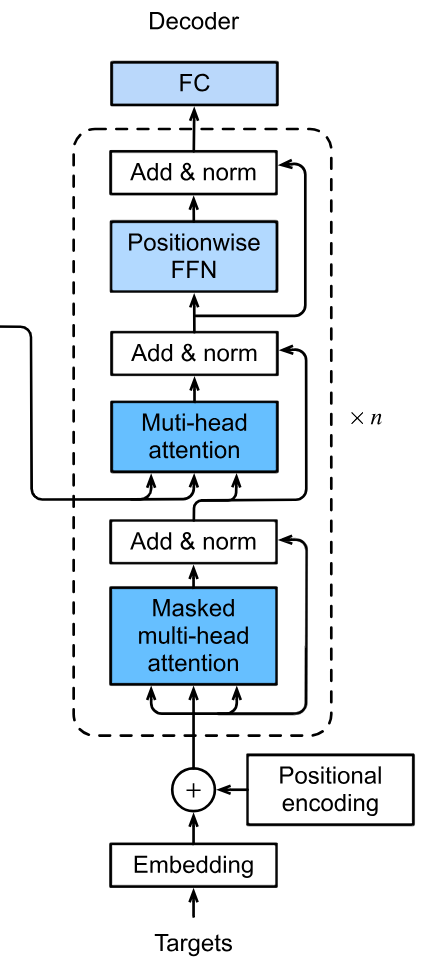

In [ ]:
class DecoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        # @TODO: fill in the blanks appropriately (given the modules above)
        self.mha1       = MultiHeadAttention(num_heads,d_model,dropout=dropout)
        self.mha2       = MultiHeadAttention(num_heads, d_model, dropout=dropout)
        self.ffn        = FeedForward(d_model,d_ff,dropout=dropout)

        self.layernorm1 = torch.nn.LayerNorm(d_model)
        self.layernorm2 = torch.nn.LayerNorm(d_model)
        self.layernorm3 = torch.nn.LayerNorm(d_model)

        self.dropout1   = torch.nn.Dropout(dropout)
        self.dropout2   = torch.nn.Dropout(dropout)
        self.dropout3   = torch.nn.Dropout(dropout)


    def forward(self, padded_targets, enc_output, enc_input_lengths, dec_enc_attn_mask, pad_mask, slf_attn_mask):

        # Masked Multi-Head Attention
        #   (1) apply MHA with the lookahead mask
        attn_output1, slf_attn_weights = self.mha1(padded_targets, padded_targets, padded_targets, mask=slf_attn_mask)

        # Skip (Residual) Connections
        #   (1) perform dropout on padded attention output
        #   (2) add the true outputs (padded_targets) as a skip connection
        attn_output1 = self.dropout1(attn_output1)
        skip_outputs = padded_targets + attn_output1


        # Layer Normalization
        #   (1) call layernorm on this resulting value
        out1 = self.layernorm1(skip_outputs)

        # Masked Multi-Head Attention on Encoder Outputs and Targets
        #   (1) apply MHA with the self-attention mask
        attn_output2, enc_dec_attn_weights = self.mha2(out1, enc_output, enc_output, mask=dec_enc_attn_mask)

        # Skip (Residual) Connections
        #   (1) perform dropout on this second padded attention output
        #   (2) add the output of first MHA block as a skip connection
        attn_output2 = self.dropout2(attn_output2)
        skip_outputs2 = out1 + attn_output2

        # Layer Normalization
        #   (1) call layernorm on this resulting value
        out2 = self.layernorm2(skip_outputs2)

        # Feed Forward Network
        #   (1) pass through the FFN
        ffn_output = self.ffn(out2)

        # Skip (Residual) Connections
        #   (1) perform dropout on the output
        #   (2) add the output of second MHA block as a skip connection
        ffn_output = self.dropout3(ffn_output)
        skip_outputs3 = out2 + ffn_output

        # apply Layer Normalization on this resulting value
        out_final = self.layernorm3(skip_outputs3)

        # return the network output and both attention weights (for mha1 and mha2)
        # @NOTE: returning the self attention weights first
        return out_final,slf_attn_weights,enc_dec_attn_weights

In [ ]:
class Decoder(torch.nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, dropout,
            target_vocab_size, max_seq_length, eos_token, sos_token, pad_token):
        super().__init__()

        self.EOS_TOKEN      = eos_token
        self.SOS_TOKEN      = sos_token
        self.PAD_TOKEN      = pad_token

        self.max_seq_length = max_seq_length
        self.num_layers     = num_layers

        # use torch.nn.ModuleList() with list comprehension looping through num_layers
        # @NOTE: think about what stays constant per each DecoderLayer (how to call DecoderLayer)
        # @HINT: We've implemented this for you.
        self.dec_layers = torch.nn.ModuleList(
            [DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)]
        )

        self.target_embedding       = torch.nn.Embedding(target_vocab_size, d_model)
        self.positional_encoding    = PositionalEncoding(d_model, max_seq_length)
        self.final_linear           = torch.nn.Linear(d_model, target_vocab_size)
        self.dropout                = torch.nn.Dropout(dropout)


    def forward(self, padded_targets, enc_output, enc_input_lengths):

        # create a padding mask for the padded_targets with <PAD_TOKEN>
        pad_mask = create_mask_1(padded_targets, pad_idx=self.PAD_TOKEN)

        # creating an attention mask for the future subsequences (look-ahead mask)
        slf_attn_mask = create_mask_2(padded_targets, pad_idx=self.PAD_TOKEN)

        # creating attention mask to ignore padding positions in the input sequence during attention calculation
        dec_enc_attn_mask = create_mask_3(enc_output, enc_input_lengths, expand_length=padded_targets.size(1))

        # computing embeddings for the target sequence
        target_embeddings = self.target_embedding(padded_targets)

        # computing Positional Encodings with the embedded targets and apply dropout
        target_embeddings = self.dropout(self.positional_encoding(target_embeddings))

        #attention weights dictionary
        attention_weights = {}

        # passing through decoder layers
        # @NOTE: store your mha1 and mha2 attention weights inside a dictionary
        # @NOTE: you will want to retrieve these later so store them with a useful name
        for i, layer in enumerate(self.dec_layers):
          target_embeddings, slf_attn_w, enc_dec_attn_w = layer(target_embeddings, enc_output, enc_input_lengths, dec_enc_attn_mask, pad_mask, slf_attn_mask)
          attention_weights[f'slf_attn_layer_{i}'] = slf_attn_w
          attention_weights[f'enc_dec_attn_layer_{i}'] = enc_dec_attn_w

        # linear layer (Final Projection) for next character prediction
        logits = self.final_linear(target_embeddings)

        # return the network output and the dictionary of attention weights
        return logits,attention_weights


    def recognize_greedy_search(self, enc_outputs, enc_input_lengths):
        ''' passes the encoder outputs and its corresponding lengths through autoregressive network

            @NOTE: You do not need to make changes to this method.
        '''

        batch_size = enc_outputs.size(0)

        # start with the <SOS> token for each sequence in the batch
        target_seq = torch.full((batch_size, 1), self.SOS_TOKEN, dtype=torch.long).to(enc_outputs.device)

        finished = torch.zeros(batch_size, dtype=torch.bool).to(enc_outputs.device)

        for _ in range(self.max_seq_length):

            # preparing attention masks
            # filled with ones becaues we want to attend to all the elements in the sequence
            pad_mask = torch.ones_like(target_seq).float().unsqueeze(-1)  # (batch_size x i x 1)
            slf_attn_mask_subseq = create_mask_2(target_seq)

            x = self.positional_encoding(self.target_embedding(target_seq))

            for i in range(self.num_layers):
                x, block1, block2 = self.dec_layers[i](
                    x, enc_outputs, enc_input_lengths, None, pad_mask, slf_attn_mask_subseq)

            seq_out = self.final_linear(x[:, -1])
            logits = torch.nn.functional.log_softmax(seq_out, dim=1)

            # selecting the token with the highest probability
            # @NOTE: this is the autoregressive nature of the network!
            next_token = logits.argmax(dim=-1).unsqueeze(1)

            # appending the token to the sequence
            target_seq = torch.cat([target_seq, next_token], dim=-1)

            # checking if <EOS> token is generated
            eos_mask = next_token.squeeze(-1) == self.EOS_TOKEN
            # or opration, if both or one of them is true store the value of the finished sequence in finished variable
            finished |= eos_mask

            # end if all sequences have generated the EOS token
            if finished.all(): break

        # remove the initial <SOS> token and pad sequences to the same length
        target_seq = target_seq[:, 1:]
        max_length = target_seq.size(1)
        target_seq = torch.nn.functional.pad(target_seq,
            (0, self.max_seq_length - max_length), value=self.PAD_TOKEN)

        return target_seq

## CNN-LSTM Encoder + Speech Transformer Decoder

In this section, let's build the first (simplest) Transformer network by combining the CNN-LSTM encoder and our Transformer Decoder.

In [ ]:
class SpeechTransformer(torch.nn.Module):

    def __init__(self, input_dim, dec_num_layers, dec_num_heads,
                    d_model, d_ff, target_vocab_size, eos_token, sos_token,
                    pad_token, enc_dropout, dec_dropout, max_seq_length=512):

        super(SpeechTransformer, self).__init__()

        self.encoder    = CNN_LSTM_Encoder(input_dim, 256, enc_dropout)

        self.proj       = torch.nn.Linear(1024, d_model)

        # @NOTE: layernorm here is meant to normalize the dynamic ranges of
        #   the cross attention weights such that the model doesn't bias
        #   itself to only using the cross attention weights and neglect using
        #   the multi-head self attention weights.
        #   This is to enfoce the Language Model constraints in the Decoder.
        #   This is an experimental change -- you may try it if you want.
        # self.layernorm  = torch.nn.LayerNorm(d_model)

        self.decoder    = Decoder(dec_num_layers, d_model, dec_num_heads, d_ff,
                dec_dropout, target_vocab_size, max_seq_length, eos_token, sos_token, pad_token)

        # You can experiment with different weight initialization schemes or no initialization here
        for p in self.parameters():
            if p.dim() > 1:
                torch.nn.init.xavier_uniform_(p)

    def forward(self, padded_input, input_lengths, padded_target, target_lengths):

        # passing through Encoder
        encoder_output, encoder_lens = self.encoder(padded_input, input_lengths)

        # adding projection layer to change dimension of encoder_outputs to match d_model
        encoder_output = self.proj(encoder_output)

        # @NOTE: adding layernorm to adjust dynamic ranges of the encoder_outputs
        # @NOTE: uncomment this if you choose to use layernorm described in __init__ above
        # encoder_output = self.layernorm(encoder_output)

        # passing Encoder output and Attention masks through Decoder
        output, attention_weights = self.decoder(padded_target, encoder_output, encoder_lens)

        return output, attention_weights

    def recognize(self, inp, inp_len):
        """ sequence-to-sequence greedy search -- decoding one utterence at a time """

        encoder_outputs, encoder_lens  = self.encoder(inp, inp_len)
        encoder_outputs                = self.proj(encoder_outputs)
        out                            = self.decoder.recognize_greedy_search(encoder_outputs, encoder_lens)

        return out

## Model Setup


In [ ]:
torch.cuda.empty_cache()
gc.collect()

17

In [ ]:
config
# {'train_dataset': 'train-clean-100',
#  'cepstral_norm': True,
#  'input_dim': 27,
#  'batch_size': 64,
#  'enc_dropout': 0.2,
#  'enc_num_layers': 1,
#  'enc_num_heads': 1,
#  'dec_dropout': 0.2,
#  'dec_num_layers': 2,
#  'dec_num_heads': 2,
#  'd_model': 512,
#  'd_ff': 2048,
#  'learning_rate': '1E-4',
#  'optimizer': 'AdamW',
#  'momentum': 0.0,
#  'nesterov': True,
#  'scheduler': 'ReduceLR',
#  'factor': 0.9,
#  'patience': 5,
#  'epochs': 100,
#  'Name': ''}

In [ ]:
''' Please refer to the config file and top sections to fill in the following '''

model = SpeechTransformer(
input_dim                   = config['input_dim'],
dec_num_layers              = config['dec_num_layers'],
dec_num_heads               = config['dec_num_heads'],


d_model                     = config['d_model'],
d_ff                        = config['d_ff'],

target_vocab_size           = len(VOCAB),
eos_token                   = EOS_TOKEN,
sos_token                   = SOS_TOKEN,
pad_token                   = PAD_TOKEN,

enc_dropout                 = config['enc_dropout'],
dec_dropout                 = config['dec_dropout'],

# decrease to a small number if you are just trying to implement the network
max_seq_length              = 550 , # Max sequence length for transcripts. Check data verification.
).to(device)

def num_parameters(mode):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params / 1E6

para = num_parameters(model)
print("#"*10)
print(f"Model Parameters:\n {para}")
print("#"*10)

##########
Model Parameters:
 18.676327
##########


### Loading the CNN-LSTM Checkpoint

---
For ease of training we use a pretrained LSTM -- load the .pth file.

In [ ]:
model.encoder.load_state_dict(torch.load("pblstm_fast_training_weights.pth"))

<All keys matched successfully>

## Loss, Optimizer, and Scheduler Definitions

In [ ]:
loss_func   = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN)
scaler      = torch.cuda.amp.GradScaler()

In [ ]:
''' defining optimizer '''

if config["optimizer"] == "SGD":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.SGD(model.parameters(),
                              lr=config["learning_rate"],
                              momentum=config["momentum"],
                              weight_decay=1E-4,
                              nesterov=config["nesterov"])

elif config["optimizer"] == "Adam":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.Adam(model.parameters(),
                               lr=float(config["learning_rate"]),
                               weight_decay=1e-4)

elif config["optimizer"] == "AdamW":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.AdamW(model.parameters(),
                                lr=float(config["learning_rate"]),
                                weight_decay=0.01)

''' defining scheduler '''

if config["scheduler"] == "ReduceLR":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                factor=config["factor"], patience=config["patience"], min_lr=1E-8, verbose=True)

elif config["scheduler"] == "CosineAnnealing":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                T_max = config["epochs"], eta_min=1E-8)

In [ ]:
def save_model(model, optimizer, scheduler, metric, epoch, path):
    torch.save(
        {"model_state_dict"         : model.state_dict(),
         "optimizer_state_dict"     : optimizer.state_dict(),
         "scheduler_state_dict"     : scheduler.state_dict() if scheduler is not None else {},
         metric[0]                  : metric[1],
         "epoch"                    : epoch},
         path
    )

def load_model(path, model, metric= "valid_acc", optimizer= None, scheduler= None):

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model_state_dict"])

    if optimizer != None:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    if scheduler != None:
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

    epoch   = checkpoint["epoch"]
    metric  = checkpoint[metric]

    return [model, optimizer, scheduler, epoch, metric]

## Training and Validation Modules

### Levenshtein Distance

In [ ]:
''' utility function which takes a sequence of indices and converts them to a list of characters '''
def indices_to_chars(indices, vocab):
    tokens = []
    for i in indices:   # looping through all indices

        if int(i) == SOS_TOKEN:     # If SOS is encountered, don't add it to the final list
            continue
        elif int(i) == EOS_TOKEN:   # If EOS is encountered, stop the decoding process
            break
        else:
            tokens.append(vocab[i])

    return tokens

In [ ]:
''' utility function for Levenshtein Distantce quantification '''
def calc_edit_distance(predictions, y, y_len, vocab=VOCAB, print_example=False):

    dist = 0.0
    batch_size, seq_len = predictions.shape

    for batch_idx in range(batch_size):

        y_sliced    = indices_to_chars(y[batch_idx, 0 : y_len[batch_idx]], vocab)
        pred_sliced = indices_to_chars(predictions[batch_idx], vocab)

        # strings - when you are using characters from the SpeechDataset
        y_string    = "".join(y_sliced)
        pred_string = "".join(pred_sliced)

        dist        += Levenshtein.distance(pred_string, y_string)

    if print_example:
        print("\nGround Truth : ", y_string)
        print("Prediction   : ", pred_string)

    dist /= batch_size

    return dist

### Training and Validation Functions

In [ ]:
def train_model(model, train_loader, optimizer):

    model.train()
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc="Train")

    total_loss          = 0
    running_loss        = 0.0
    running_perplexity  = 0.0

    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(train_loader):

        optimizer.zero_grad()

        inputs          = inputs.to(device)
        targets_shifted = targets_shifted.to(device)
        targets_golden  = targets_golden.to(device)

        with torch.cuda.amp.autocast():
            # passing the minibatch through the model
            raw_predictions, attention_weights = model(inputs, inputs_lengths, targets_shifted, targets_lengths)

            padding_mask = torch.logical_not(torch.eq(targets_shifted, PAD_TOKEN))

            # cast the mask to float32
            padding_mask = padding_mask.float()
            loss = loss_func(raw_predictions.transpose(1,2), targets_golden)*padding_mask
            loss = loss.sum() / padding_mask.sum()

        scaler.scale(loss).backward()   # This is a replacement for loss.backward()
        scaler.step(optimizer)          # This is a replacement for optimizer.step()
        scaler.update()                 # This is something added just for FP16

        running_loss        += float(loss.item())
        perplexity          = torch.exp(loss)
        running_perplexity  += perplexity.item()

        # online training monitoring
        batch_bar.set_postfix(
            loss = "{:.04f}".format(float(running_loss / (i + 1))),
            perplexity = "{:.04f}".format(float(running_perplexity / (i + 1)))
        )

        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()

    running_loss        = float(running_loss / len(train_loader))
    running_perplexity  = float(running_perplexity / len(train_loader))

    batch_bar.close()

    return running_loss, running_perplexity, attention_weights

In [ ]:
def validate_fast(model, dataloader):
    model.eval()

    # progress bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc="Val", ncols=5)

    running_distance = 0.0

    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(dataloader):

        inputs  = inputs.to(device)
        targets_golden = targets_golden.to(device)

        with torch.inference_mode():
            greedy_predictions = model.recognize(inputs, inputs_lengths)

        # calculating Levenshtein Distance
        # @NOTE: modify the print_example to print more or less validation examples
        running_distance += calc_edit_distance(greedy_predictions, targets_golden, targets_lengths, VOCAB, print_example=True)

        # online validation distance monitoring
        batch_bar.set_postfix(
            running_distance = "{:.04f}".format(float(running_distance / (i + 1)))
        )

        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()

        if i==4: break      # validating only upon first five batches

    batch_bar.close()
    running_distance /= 5

    return running_distance

In [ ]:
def validate_full(model, dataloader):
    model.eval()

    # progress bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc="Val", ncols=5)

    running_distance = 0.0

    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(dataloader):

        inputs  = inputs.to(device)
        targets_golden = targets_golden.to(device)

        with torch.inference_mode():
            greedy_predictions = model.recognize(inputs, inputs_lengths)

        # calculating Levenshtein Distance
        # @NOTE: modify the print_example to print more or less validation examples
        running_distance += calc_edit_distance(greedy_predictions, targets_golden, targets_lengths, VOCAB, print_example=True)

        # online validation distance monitoring
        batch_bar.set_postfix(
            running_distance = "{:.04f}".format(float(running_distance / (i + 1)))
        )

        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()


    batch_bar.close()
    running_distance /= len(dataloader)

    return running_distance

## WandB

In [ ]:
# using WandB? resume training?

USE_WANDB = True
RESUME_LOGGING = True

# creating your WandB run
run_name = "{}_Transformer_ENC-{}/{}_DEC-{}/{}_{}_{}_{}_{}".format(
    config["Name"],
    config["enc_num_layers"],       # only used in Part II with the Transformer Encoder
    config["enc_num_heads"],        # only used in Part II with the Transformer Encoder
    config["dec_num_layers"],
    config["dec_num_heads"],
    config["d_model"],
    config["d_ff"],
    config["optimizer"],
    config["scheduler"])

if USE_WANDB:

    wandb.login(key="", relogin=True) # TODO enter your key here

    if RESUME_LOGGING:
        run_id = ''
        run = wandb.init(
            id     = run_id,        ### Insert specific run id here if you want to resume a previous run
            resume = True,          ### You need this to resume previous runs, but comment out reinit=True when using this
            project = "",  ### Project should be created in your wandb account
        )

    else:
        run = wandb.init(
            name    = run_name,     ### Wandb creates random run names if you skip this field, we recommend you give useful names
            reinit  = True,         ### Allows reinitalizing runs when you re-run this cell
            project = "",  ### Project should be created in your wandb account
            config  = config        ### Wandb Config for your run
        )

        ### Save your model architecture as a string with str(model)
        model_arch  = str(model)

        ### Save it in a txt file
        arch_file   = open("model_arch.txt", "w")
        file_write  = arch_file.write(model_arch)
        arch_file.close()

        ### Log it in your wandb run with wandb.save()
        wandb.save("model_arch.txt")

        

<style>
    table.wandb td:nth-child(1) { padding: 0 10px; text-align: left ; width: auto;} td:nth-child(2) {text-align: left ; width: 100%}
    .wandb-row { display: flex; flex-direction: row; flex-wrap: wrap; justify-content: flex-start; width: 100% }
    .wandb-col { display: flex; flex-direction: column; flex-basis: 100%; flex: 1; padding: 10px; }
    </style>
<div class="wandb-row"><div class="wandb-col"><h3>Run summary:</h3><br/><table class="wandb"><tr><td>learning_rate</td><td>0.0001</td></tr><tr><td>train_loss</td><td>0.6243</td></tr><tr><td>train_perplexity</td><td>1.86744</td></tr><tr><td>val_distance</td><td>58.20625</td></tr></table><br/></div></div>

## Experiments

In [ ]:
RESUME_LOGGING = True

In [ ]:
e                   = 0
best_loss           = 20

checkpoint_root = os.path.join(os.getcwd(), "checkpoints-basic-transformer")
os.makedirs(checkpoint_root, exist_ok=True)
wandb.watch(model, log="all")

checkpoint_best_loss_model_filename     = 'checkpoint-best-loss-model.pth'
checkpoint_last_epoch_filename          = 'checkpoint-epoch-'
best_loss_model_path                    = os.path.join(checkpoint_root, checkpoint_best_loss_model_filename)

if RESUME_LOGGING:
    # change if you want to load best test model accordingly
    checkpoint = torch.load('/content/checkpoint-best-loss-model.pth')

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    e = checkpoint['epoch']

    print("Resuming from epoch {}".format(e+1))
    print("Epochs left: ", config['epochs']-e)
    print("Optimizer: \n", optimizer)

torch.cuda.empty_cache()
gc.collect()

epochs = config["epochs"]
for epoch in range(e, epochs):

    print("\nEpoch {}/{}".format(epoch+1, config["epochs"]))

    curr_lr = float(optimizer.param_groups[0]["lr"])

    train_loss, train_perplexity, attention_weights = train_model(model, train_loader, optimizer)

    print("\nEpoch {}/{}: \nTrain Loss {:.04f}\t Train Perplexity {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config["epochs"], train_loss, train_perplexity, curr_lr))

    if (epoch % 2 == 0):    # validate every 2 epochs to speed up training
        levenshtein_distance = validate_fast(model, val_loader)
        print("Levenshtein Distance {:.04f}".format(levenshtein_distance))

        wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr,
                "val_distance"      : levenshtein_distance})

    else:
        wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr})

    # plotting the encoder-nearest and decoder-nearest attention weights
    attention_keys = list(attention_weights.keys())

    attention_weights_decoder_self       = attention_weights[attention_keys[0]][0].cpu().detach().numpy()
    attention_weights_decoder_cross      = attention_weights[attention_keys[-1]][0].cpu().detach().numpy()

    # saving the cross-attention weights
    save_attention_plot(attention_weights_decoder_cross, epoch+100)

    #plot_attention_weights((attention_weights[attention_keys[0]][0]).cpu().detach().numpy())
    #plot_attention_weights(attention_weights[attention_keys[-1]][0].cpu().detach().numpy())

    if config["scheduler"] == "ReduceLR":
        scheduler.step(levenshtein_distance)
    else:
        scheduler.step()

    ### Highly Recommended: Save checkpoint in drive and/or wandb if accuracy is better than your current best
    epoch_model_path = os.path.join(checkpoint_root, (checkpoint_last_epoch_filename + str(epoch) + '.pth'))
    save_model(model, optimizer, scheduler, ['train_loss', train_loss], epoch, epoch_model_path)
    #wandb.save(epoch_model_path) ## Can't save on wandb for all epochs, may blow up storage

    print("Saved epoch model")

    if best_loss >= train_loss:
        best_loss = train_loss
        save_model(model, optimizer, scheduler, ['train_loss', train_loss], epoch, best_loss_model_path)
        wandb.save(best_loss_model_path)
        print("Saved best training model")

### Finish your wandb run
# run.finish()

Resuming from epoch 20
Epochs left:  131
Optimizer: 
 AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.01
)



Epoch 20/150



Epoch 20/150: 
Train Loss 0.3458	 Train Perplexity 1.4133	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 21/150



Epoch 21/150: 
Train Loss 0.3301	 Train Perplexity 1.3913	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:31<21:43, 31.05s/it, running_distance=43.8906]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH OF A NABLE SOME IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE WERE AND THE PROME A SHE AND THE COULD AND THE READ A SHE WERE THE PRETTER AT BE AND THE PREATING A LITTLE IT AND THE PRET AND THE PREATION A SHE AS A THE EAD A PAY A SHEAD AND HEALS


Val:   5%|▍         | 2/43 [00:51<16:45, 24.53s/it, running_distance=37.6172]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:01<30:20, 45.52s/it, running_distance=43.7969]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARRIL EXPOSED HIM TO THE PENNELT HIS OF THE JEWLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPPER SISSUS AGE A MISSUS AND THE COULD THE WERE THE PROSE


Val:   9%|▉         | 4/43 [03:18<37:47, 58.14s/it, running_distance=48.5430]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND DESCHEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [04:36<41:15, 65.15s/it, running_distance=52.1625]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEW PIN WITH SUFFICIENT WANTER TO COVERT LET IT STUGENTLY TO QUITE OUT TO COUL


Levenshtein Distance 52.1625
Saved epoch model
Saved best training model

Epoch 22/150



Epoch 22/150: 
Train Loss 0.3161	 Train Perplexity 1.3720	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 23/150



Epoch 23/150: 
Train Loss 0.3038	 Train Perplexity 1.3551	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:34<24:04, 34.38s/it, running_distance=41.9531]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH OF A NABLE SOME IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE WERE A SHE A BEEN A LIKE A LITTLE AND A LIKE A PEART AND THE WERE AND A BEEN A LEART AND A GOOD A LIKE A PAY A BEEN A PEART AND BECAUTION THE DEART AND HE WERE AND HEALS


Val:   5%|▍         | 2/43 [01:42<37:12, 54.44s/it, running_distance=40.1953]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY AND GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:14<29:17, 43.94s/it, running_distance=41.9688]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARRIL EXPOSED HIM TO THE PENELTY'S OF THE JEWLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE A FOR A LITTLE AND A LITTLE IT A PRENT A LITTLE IT A PEART AND EVEN OF PRAIS


Val:   9%|▉         | 4/43 [02:49<26:21, 40.56s/it, running_distance=45.3789]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND DESCHEP MORE AT MORE IT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [04:07<34:07, 53.87s/it, running_distance=49.0781]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEW PIN WITH SUFFICIENT WANTER TO COVERT LET ITS TUGENTLY TO QUITE OUT TO COUL


Levenshtein Distance 49.0781
Saved epoch model
Saved best training model

Epoch 24/150



Epoch 24/150: 
Train Loss 0.2929	 Train Perplexity 1.3404	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 25/150



Epoch 25/150: 
Train Loss 0.2831	 Train Perplexity 1.3275	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:30<21:35, 30.84s/it, running_distance=40.3750]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH OF A NABLE SOME IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HAD A CAN THE CAN IN THE COULD AND A GUINED A BEEN A SEENT A BUT A LITTLE IT AND THE WAS THE PROMENT A BEEN A BEEN A THE PRENT AND THE CAN THE DIEW AS THE BEEN A HILS


Val:   5%|▍         | 2/43 [01:39<36:08, 52.90s/it, running_distance=36.2578]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:49<40:36, 60.92s/it, running_distance=38.6458]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARRIL EXPOSED HIM TO THE PENNELTY'S OF THE JEWLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE A NOT A LITTLE AND A GUINED A BUT A MISSUS AND EVEN OF PRAIS


Val:   9%|▉         | 4/43 [04:06<43:43, 67.28s/it, running_distance=42.0703]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND DESCHEP MORE AT MORE IT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [05:24<44:55, 70.92s/it, running_distance=47.0312]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEW PIN WITH SUFFICIENT WANTER TO COVERT LET ITS TO GENTLY TO QUITE OUT TO COOL


Levenshtein Distance 47.0312
Saved epoch model
Saved best training model

Epoch 26/150



Epoch 26/150: 
Train Loss 0.2728	 Train Perplexity 1.3138	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 27/150



Epoch 27/150: 
Train Loss 0.2640	 Train Perplexity 1.3023	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [01:19<55:39, 79.52s/it, running_distance=44.8438]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH OF A NABLE SOME ONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE MAY A GINER A LITTLE AND THE WAS A BEEN A GUINED A BEEN A SEPT AND THE WERE AND THE WERE TO BE A NEW AS IN A GUITY AND THE BEEN A CALL THE READ A SET A BEEN A ND HEELS


Val:   5%|▍         | 2/43 [02:27<49:46, 72.84s/it, running_distance=44.2734]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [03:37<47:46, 71.67s/it, running_distance=46.7240]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARRIL EXPOSED HIM TO THE PENNELTIES OF THE JEWLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE A NOT A LITTLE AND THE WENTY A BEEN OF PRAISE


Val:   9%|▉         | 4/43 [04:55<47:57, 73.79s/it, running_distance=49.1953]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND DESCHEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [06:12<47:38, 75.23s/it, running_distance=54.9250]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEW PEN WITH SUFFICIENT WANTER TO COVERT LET ITS STUGENTLY TO QUITE DONE WHEN TAKE IN A BEEN A LITTLE AND IT WAS A GOOD A LITTLE AND IT A BEEN A GETTLED AND THE WERE A NEW THE COULD THE WAS A BEEN A GAIN THE CONVER THE PEONT OF THE MAY THE BEEN A BEEN TO COUL


Levenshtein Distance 54.9250
Saved epoch model
Saved best training model

Epoch 28/150



Epoch 28/150: 
Train Loss 0.2561	 Train Perplexity 1.2920	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 29/150



Epoch 29/150: 
Train Loss 0.2482	 Train Perplexity 1.2818	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [01:19<55:26, 79.20s/it, running_distance=39.5156]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH OF A NABLE SOME IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD A CAME A CAME A CAUTING A CAN A LITTLE IN THE CAN A BEEN A BEEN A BEEN A BEEN A BEEN A BEEN A BEEN A DEAR THE PERITION THE BEEN A BEEN A DEAD THE BEEN A THE BEEN A HELS


Val:   5%|▍         | 2/43 [01:41<31:08, 45.58s/it, running_distance=32.2500]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:50<37:32, 56.32s/it, running_distance=37.1615]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARRIL EXPOSED HIM TO THE PENNELT HIS OF THE JULLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE HER THE PART AND A CAN IN THE COULD THE PROMES


Val:   9%|▉         | 4/43 [03:18<29:21, 45.17s/it, running_distance=40.1484]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND DESCHEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [03:45<24:29, 38.67s/it, running_distance=40.7656]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STEW PEN WITH SUFFICIENT WANTER TO COVERT LET ITS TO GENTLY TILL QUITE OUT TO COOL


Levenshtein Distance 40.7656
Saved epoch model
Saved best training model

Epoch 30/150



Epoch 30/150: 
Train Loss 0.2411	 Train Perplexity 1.2727	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 31/150



Epoch 31/150: 
Train Loss 0.2347	 Train Perplexity 1.2647	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [01:19<55:28, 79.25s/it, running_distance=46.5156]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH OF A NABLES SOME IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD A COULD AND THE COULD AND A BEEN THE COULD THE READ A PRENT AND THE WERE A SET AND THE CAN A BEEN A SHE WEAT AND THE WERE A BEEN THE CAN A BEEN A THE PEOPLED STIFF AND UNISE THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [02:27<49:38, 72.64s/it, running_distance=37.8125]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [03:37<47:42, 71.57s/it, running_distance=41.8854]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARREL EXPOSED HIM TO THE PENNELTIES OF THE JEWLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE HER A NOT A MIGHT AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [04:54<47:54, 73.71s/it, running_distance=46.0586]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND DESCHEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [06:12<47:34, 75.12s/it, running_distance=50.1562]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEW PIN WITH SUFFICIENT WANTER TO COVERT LET ITS TO GENTLY TILL QUITE OUT TO COOL


Levenshtein Distance 50.1562
Saved epoch model
Saved best training model

Epoch 32/150



Epoch 32/150: 
Train Loss 0.2282	 Train Perplexity 1.2564	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 33/150



Epoch 33/150: 
Train Loss 0.2220	 Train Perplexity 1.2486	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:27<19:26, 27.77s/it, running_distance=32.4375]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH OF A NABLES SOME ON IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HAD A BEEN A SED A BEEN A BEEN A BEEN A BUT A BEEN A BUT A BEEN A BUT AND THE PERT UP A LITTLE IT A BEEN A BUT ANY A NEW ERE THE BEEN A SHOULD AND HEALS


Val:   5%|▍         | 2/43 [01:36<35:18, 51.66s/it, running_distance=31.8672]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:46<40:10, 60.27s/it, running_distance=34.5156]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARREL EXPOSED HIM TO THE PENNELTIES OF THE JEWLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE COULD THE WAS A BEEN OF PRAISE


Val:   9%|▉         | 4/43 [04:03<43:29, 66.92s/it, running_distance=39.5469]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCHEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [05:21<44:44, 70.65s/it, running_distance=43.6594]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEW PIN WITH SUFFICIENT WANTER TO COVERT LET ITS TO GENTLY TILL QUITE OUT TO COOL


Levenshtein Distance 43.6594
Saved epoch model
Saved best training model

Epoch 34/150



Epoch 34/150: 
Train Loss 0.2170	 Train Perplexity 1.2424	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 35/150



Epoch 35/150: 
Train Loss 0.2112	 Train Perplexity 1.2352	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:29<20:39, 29.50s/it, running_distance=31.6562]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH OF A NABLES SOMEN IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD A GIRE THE CAN EAR THE CAN A LIEUR THE PROMISED AND A BEEN A LITTLE IN THE CAN IT A BEEN A BEEN A BUT A BEEN A BUT IT ELL BE TO HER TO BE A MIGHT AND HEELS


Val:   5%|▍         | 2/43 [00:53<18:07, 26.52s/it, running_distance=28.5781]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:04<31:09, 46.73s/it, running_distance=32.1146]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNELT HIS OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [03:22<38:13, 58.82s/it, running_distance=36.7734]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [04:39<41:34, 65.65s/it, running_distance=39.7687]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEW PIN WITH SUFFICIENT WANTER TO COVERNED LET ITS TO GENTLY TILL QUITE OUT TO COOL


Levenshtein Distance 39.7687
Saved epoch model
Saved best training model

Epoch 36/150



Epoch 36/150: 
Train Loss 0.2065	 Train Perplexity 1.2295	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 37/150



Epoch 37/150: 
Train Loss 0.2012	 Train Perplexity 1.2230	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:29<20:53, 29.86s/it, running_distance=29.0469]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH OF A NABLES SOME ONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD A BEEN A SEAR A BEEN A STER A LITTLE AND THE BEEN A LITTLE AND THE BEEN A BEEN A LITTLE AND A BEEN A BEEN A BEEN A BEEN A DID THE MIDDER AND HEALS


Val:   5%|▍         | 2/43 [00:51<16:58, 24.85s/it, running_distance=26.0938]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:01<30:27, 45.68s/it, running_distance=29.1250]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARREL EXPOSED HIM TO THE PENNELTIES OF THE JULLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE HE WAS THE COULD THE WERE A NOT A BEEN OF PRAISE


Val:   9%|▉         | 4/43 [02:31<25:43, 39.59s/it, running_distance=33.7539]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCHEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [03:49<33:44, 53.27s/it, running_distance=35.7281]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEW PEN WITH SUFFICIENT WANTER TO COVERT LET ITS TO GENTLY TILL QUITE OUT TO COOL


Levenshtein Distance 35.7281
Saved epoch model
Saved best training model

Epoch 38/150



Epoch 38/150: 
Train Loss 0.1968	 Train Perplexity 1.2176	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 39/150



Epoch 39/150: 
Train Loss 0.1920	 Train Perplexity 1.2118	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [01:19<55:32, 79.34s/it, running_distance=32.2812]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH OF A NABLES SOME ONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HAD A BEEN THE CARE THE PERT A BEEN THE WERE AND A BEEN A SET AND THE CARE THE BEEN A BEEN A CALLED AND A BEEN A SET AND A BEEN THE CAN IT A BEEN A THE MY AND HEELS


Val:   5%|▍         | 2/43 [01:44<32:37, 47.74s/it, running_distance=27.4297]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:55<38:46, 58.16s/it, running_distance=29.7188]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNELTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [03:23<30:09, 46.40s/it, running_distance=31.7266]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [04:41<36:33, 57.73s/it, running_distance=35.6500]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEW PIN WITH SUFFICIENT WANTER TO COVERT LET ITS TO GENTLY TILL QUITE DONE WHEN TAKE IT OF THE READ A BEEN A CALLED A GET A BEEN A CALLED AND THE CARE THE WERE A BEEN A SERE THE PROMENT AND A BEEN THE CARE IT AND A BEEN A DEAR AND A BEEN A CALLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Levenshtein Distance 35.6500
Saved epoch model
Saved best training model

Epoch 40/150



Epoch 40/150: 
Train Loss 0.1878	 Train Perplexity 1.2067	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 41/150



Epoch 41/150: 
Train Loss 0.1843	 Train Perplexity 1.2024	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [01:19<55:29, 79.28s/it, running_distance=33.8438]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH OF A NABLES SOME IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD A CAN A LITTLE AND A LITTLE AND THE PERE A NITH A BEEN A LITTLE AND THE BEEN A LITTLE AND THE COULD IN A BEEN A SERT AND A BEEN A LITTLE AND HEALS


Val:   5%|▍         | 2/43 [01:40<30:40, 44.89s/it, running_distance=28.2266]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:50<37:46, 56.66s/it, running_distance=28.4688]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNELTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [03:20<29:57, 46.08s/it, running_distance=31.6992]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCHEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [04:38<36:25, 57.53s/it, running_distance=35.6844]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANTER TO COVERT LET ITS TO GENTLY TILL QUITE DONE WHEN TAKE IT OF THE MERE A NEW THE ARE THE WERE A NITER THE MAY THE BEEN A FERENT A LITTLE AND THE CAN A LITTLE AND A BEEN A LITTLE AND THE CAN THE CAN A NEW THEN TAKE IT OUT TO COOL


Levenshtein Distance 35.6844
Saved epoch model
Saved best training model

Epoch 42/150



Epoch 42/150: 
Train Loss 0.1804	 Train Perplexity 1.1978	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 43/150



Epoch 43/150: 
Train Loss 0.1763	 Train Perplexity 1.1928	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:28<19:58, 28.53s/it, running_distance=29.5938]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF A NABLES SOME ONE IN A TRANCE TO HOLDES BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS AND A GREATER AND A COULD THE BEEN A BEEN A SEAT AND A BEEN A BEEN A LITTLE AND A BEEN A CAUTIVE THE BEEN A BEEN A DIRE A BEEN A BEEN A CALLED HER AND HEELS


Val:   5%|▍         | 2/43 [00:50<16:41, 24.44s/it, running_distance=26.1094]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:15<16:42, 25.07s/it, running_distance=26.7292]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNELTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:44<17:18, 26.62s/it, running_distance=30.3164]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCHEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [02:13<17:19, 27.35s/it, running_distance=31.9187]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANTER TO COVERT LET ITS TO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COULD AND A BEEN AND THE GOOD AND A BEEN A BEEN A SEAT AND THE BEEN A BEEN A LITTLE AND A CALLED AND A BEEN AND THE BEEN A BEEN A BEEN A SERE THE BEEN A BEEN A CANOT OUL


Levenshtein Distance 31.9187
Saved epoch model
Saved best training model

Epoch 44/150



Epoch 44/150: 
Train Loss 0.1728	 Train Perplexity 1.1888	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 45/150



Epoch 45/150: 
Train Loss 0.1696	 Train Perplexity 1.1849	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:29<20:22, 29.12s/it, running_distance=29.2969]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH OF A NABLES SOME IN A TRANCE TO HOLDER'S BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS A MANY A CAME THE WERE TO THE MISSUE AND THE COULD THE WERE THE WERE A BEEN THE CAN'T A BEEN A BEEN THE WERE TO BE THEN YET AND HEALS


Val:   5%|▍         | 2/43 [00:53<18:10, 26.60s/it, running_distance=25.7031]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:19<17:32, 26.32s/it, running_distance=26.2031]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNELT HIS OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:48<17:47, 27.37s/it, running_distance=28.7109]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCEP MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [02:16<17:17, 27.30s/it, running_distance=29.5469]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANTER TO COVERT LET ITS DUE GENTLY TILL QUITE OUT TO COOL


Levenshtein Distance 29.5469
Saved epoch model
Saved best training model

Epoch 46/150



Epoch 46/150: 
Train Loss 0.1661	 Train Perplexity 1.1807	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 47/150



Epoch 47/150: 
Train Loss 0.1630	 Train Perplexity 1.1772	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:28<19:59, 28.57s/it, running_distance=29.7031]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH OF A NABLES SOME ONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS AND A COULD AND A CHOIN A BEEN A LEAR THE READ AND A NEW THE BEEN A LEAD AND A BEEN A CAN A BEEN A NEW THE BEEN A DEAR THE MAY AND HEELS


Val:   5%|▍         | 2/43 [00:51<17:25, 25.50s/it, running_distance=24.6484]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:15<16:19, 24.50s/it, running_distance=25.0573]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNELTIES OF THE JULLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:42<16:40, 25.66s/it, running_distance=29.5352]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WEET RANGE WATER LAST LONGER AND ESCHEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [02:11<16:53, 26.67s/it, running_distance=30.0219]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANTER TO COVERT LET ITS TO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COUL


Levenshtein Distance 30.0219
Saved epoch model
Saved best training model

Epoch 48/150



Epoch 48/150: 
Train Loss 0.1598	 Train Perplexity 1.1734	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 49/150



Epoch 49/150: 
Train Loss 0.1573	 Train Perplexity 1.1705	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:25<17:52, 25.55s/it, running_distance=26.1719]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF A NABLES SOME ONE IN A TRANCE TO HOLDES BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEALT IN A CONTER A BEEN A LIEUR A BEEN A LITTLE AND A COULD HE WERE A NEW A LEADY AND A CALLED AND A CARELY AND A BEEN A CALLED YOU AND HEALS


Val:   5%|▍         | 2/43 [00:44<14:48, 21.66s/it, running_distance=22.2969]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:09<15:33, 23.34s/it, running_distance=23.2292]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNELTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:35<15:41, 24.13s/it, running_distance=25.9922]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  FEET RANGE WATER LAST LONGER AND ESCHEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [02:05<16:47, 26.50s/it, running_distance=26.9469]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET ITS TOO GENTLY TILL QUITE OUT TO COOL


Levenshtein Distance 26.9469
Saved epoch model
Saved best training model

Epoch 50/150



Epoch 50/150: 
Train Loss 0.1544	 Train Perplexity 1.1671	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 51/150



Epoch 51/150: 
Train Loss 0.1515	 Train Perplexity 1.1636	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:28<19:55, 28.47s/it, running_distance=22.8594]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF A NABLES SOMEON IN A TRANCE TO HOLDER'S BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:47<15:32, 22.75s/it, running_distance=20.6406]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:06<14:12, 21.31s/it, running_distance=19.5365]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNELTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:35<15:46, 24.27s/it, running_distance=23.7656]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCHEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [02:03<16:08, 25.49s/it, running_distance=24.8500]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERNT LET ITS TO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL THE SHOOT A BEEN A LITTLE AND A LEAD A BEEN A LITTLE AND A LEAD A MANY A LITTLE AND A BEEN A BEEN A DEPT A LITTLE AND THE MAY AND A KEN A BEEN TAKE IT OUT TO COOL


Levenshtein Distance 24.8500
Saved epoch model
Saved best training model

Epoch 52/150



Epoch 52/150: 
Train Loss 0.1488	 Train Perplexity 1.1605	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 53/150



Epoch 53/150: 
Train Loss 0.1465	 Train Perplexity 1.1578	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:25<17:32, 25.06s/it, running_distance=25.2188]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF A NABLES SOME IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:44<15:00, 21.96s/it, running_distance=21.6172]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:06<14:39, 21.98s/it, running_distance=21.0260]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNELT HIS OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:31<14:54, 22.94s/it, running_distance=24.9180]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCHEP MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [01:59<15:50, 25.01s/it, running_distance=25.0094]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET ITS TO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Levenshtein Distance 25.0094
Saved epoch model
Saved best training model

Epoch 54/150



Epoch 54/150: 
Train Loss 0.1438	 Train Perplexity 1.1548	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 55/150



Epoch 55/150: 
Train Loss 0.1413	 Train Perplexity 1.1518	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:27<19:21, 27.65s/it, running_distance=24.9844]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF A NABLES SOME IN A TRANCE TO HOLDOW'S BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:48<16:04, 23.52s/it, running_distance=20.8750]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:12<15:52, 23.80s/it, running_distance=19.2760]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNELT HIS OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:39<16:21, 25.16s/it, running_distance=23.5938]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [02:08<16:46, 26.50s/it, running_distance=23.5750]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ATTER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LETTED STOO GENTLY TILL QUITE OUT TO COOL


Levenshtein Distance 23.5750
Saved epoch model
Saved best training model

Epoch 56/150



Epoch 56/150: 
Train Loss 0.1392	 Train Perplexity 1.1494	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 57/150



Epoch 57/150: 
Train Loss 0.1367	 Train Perplexity 1.1465	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:29<20:59, 29.98s/it, running_distance=24.8906]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINK THE ENABLES SOME ONE IN A TRANCE TO HOLDOWS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:53<17:55, 26.24s/it, running_distance=21.0391]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:19<17:17, 25.93s/it, running_distance=20.3281]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNELD HE'S OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:48<17:40, 27.19s/it, running_distance=23.5000]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCEPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [02:17<17:44, 28.01s/it, running_distance=23.6594]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ETTER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LETTED STUE GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Levenshtein Distance 23.6594
Saved epoch model
Saved best training model

Epoch 58/150



Epoch 58/150: 
Train Loss 0.1344	 Train Perplexity 1.1439	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 59/150



Epoch 59/150: 
Train Loss 0.1321	 Train Perplexity 1.1413	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:27<19:34, 27.97s/it, running_distance=25.3906]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF AN NABLES SOME IN A TRANCE TO HOLDOW'S BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:47<15:55, 23.30s/it, running_distance=20.9922]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:12<15:47, 23.69s/it, running_distance=19.7708]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNELTIES OF THE JEWLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:42<17:04, 26.28s/it, running_distance=23.6172]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WEET RANGE WATER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [02:11<17:10, 27.13s/it, running_distance=24.3875]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LETTED STUE GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Levenshtein Distance 24.3875
Saved epoch model
Saved best training model

Epoch 60/150



Epoch 60/150: 
Train Loss 0.1307	 Train Perplexity 1.1397	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 61/150



Epoch 61/150: 
Train Loss 0.1283	 Train Perplexity 1.1370	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:27<19:13, 27.48s/it, running_distance=25.6875]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF AN ABLES SOMEONE IN A TRANCE TO HOLDES BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:47<15:49, 23.16s/it, running_distance=20.8125]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:09<15:07, 22.69s/it, running_distance=19.8750]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNELTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:39<16:34, 25.50s/it, running_distance=24.2734]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WEET RANGE WATER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [02:08<16:55, 26.71s/it, running_distance=24.6250]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPIN WITH SUFFICIENT WANDER TO COVERT LETTED STOO GENTLY TILL QUITE OUT TO COOL


Levenshtein Distance 24.6250
Epoch 00054: reducing learning rate of group 0 to 9.0000e-05.
Saved epoch model
Saved best training model

Epoch 62/150



Epoch 62/150: 
Train Loss 0.1254	 Train Perplexity 1.1337	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 63/150



Epoch 63/150: 
Train Loss 0.1233	 Train Perplexity 1.1312	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:26<18:34, 26.53s/it, running_distance=25.2656]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINK THE ENABLES SOMEONE IN A TRANCE TO HOLDER'S BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:44<14:29, 21.21s/it, running_distance=19.1172]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:11<16:01, 24.03s/it, running_distance=19.0417]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNELD HE'S OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:38<16:29, 25.37s/it, running_distance=21.6211]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  FEET RANGE WATER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [02:07<16:49, 26.56s/it, running_distance=21.8438]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LETTED STOO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Levenshtein Distance 21.8438
Saved epoch model
Saved best training model

Epoch 64/150



Epoch 64/150: 
Train Loss 0.1214	 Train Perplexity 1.1291	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 65/150



Epoch 65/150: 
Train Loss 0.1199	 Train Perplexity 1.1274	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:28<19:59, 28.55s/it, running_distance=24.6719]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF A NABLES SOMEN IN A TRANCE TO HOLDOW'S BODY STIFF AND UNSUMPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:51<17:06, 25.03s/it, running_distance=20.3828]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:13<15:50, 23.76s/it, running_distance=18.3594]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNELD HE'S OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:38<15:49, 24.34s/it, running_distance=21.7773]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WEET RANGE WATER LAST LONGER AND ESCAPED MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [02:06<16:19, 25.77s/it, running_distance=22.5000]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LETTED STUE GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Levenshtein Distance 22.5000
Saved epoch model
Saved best training model

Epoch 66/150



Epoch 66/150: 
Train Loss 0.1184	 Train Perplexity 1.1257	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 67/150



Epoch 67/150: 
Train Loss 0.1168	 Train Perplexity 1.1240	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:28<19:47, 28.27s/it, running_distance=23.9219]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH THE NABLES SOMEN IN A TRANCE TO HOLDERS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:47<15:49, 23.16s/it, running_distance=20.3125]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:13<16:15, 24.38s/it, running_distance=19.0729]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNEL HIS OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:39<16:07, 24.79s/it, running_distance=23.0898]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  FEET RANGE WATER LAST LONGER AND ESCHEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [02:07<16:33, 26.13s/it, running_distance=22.9531]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET ITS TO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Levenshtein Distance 22.9531
Saved epoch model
Saved best training model

Epoch 68/150



Epoch 68/150: 
Train Loss 0.1153	 Train Perplexity 1.1222	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 69/150



Epoch 69/150: 
Train Loss 0.1140	 Train Perplexity 1.1208	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:29<20:27, 29.22s/it, running_distance=22.8750]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH THE NABLES SOMEONE IN A TRANCE TO HOLDA'S BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:48<15:49, 23.16s/it, running_distance=18.4297]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:12<15:43, 23.59s/it, running_distance=17.1250]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNELT HIS OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:40<16:36, 25.56s/it, running_distance=19.9375]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  FEET RANGE WATER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [02:07<16:32, 26.13s/it, running_distance=20.7937]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ETTER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LETTED STOO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Levenshtein Distance 20.7937
Saved epoch model
Saved best training model

Epoch 70/150



Epoch 70/150: 
Train Loss 0.1124	 Train Perplexity 1.1190	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 71/150



Epoch 71/150: 
Train Loss 0.1109	 Train Perplexity 1.1173	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:29<20:21, 29.08s/it, running_distance=24.9688]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLDA'S BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:52<17:42, 25.91s/it, running_distance=21.3281]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:17<16:46, 25.17s/it, running_distance=19.4167]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNELD HESE OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:46<17:21, 26.70s/it, running_distance=22.6953]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  FEET RANGE WATER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [02:14<17:23, 27.47s/it, running_distance=23.1375]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET ITS TOO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Levenshtein Distance 23.1375
Saved epoch model
Saved best training model

Epoch 72/150



Epoch 72/150: 
Train Loss 0.1089	 Train Perplexity 1.1151	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 73/150



Epoch 73/150: 
Train Loss 0.1078	 Train Perplexity 1.1138	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:30<21:37, 30.90s/it, running_distance=24.8125]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEN IN A TRANCE TO HOLOUS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:50<16:34, 24.25s/it, running_distance=20.2031]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:14<16:10, 24.25s/it, running_distance=18.2917]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNELD HIS OF THE JULY IN LAW THUS IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:47<18:03, 27.78s/it, running_distance=21.7266]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [02:18<18:14, 28.79s/it, running_distance=21.5375]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ETTER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET ITS TOO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Levenshtein Distance 21.5375
Saved epoch model
Saved best training model

Epoch 74/150



Epoch 74/150: 
Train Loss 0.1067	 Train Perplexity 1.1127	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 75/150



Epoch 75/150: 
Train Loss 0.1053	 Train Perplexity 1.1111	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:29<20:28, 29.25s/it, running_distance=24.6250]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEON IN A TRANCE TO HOLDOES BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:48<15:55, 23.30s/it, running_distance=20.0078]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:12<15:45, 23.63s/it, running_distance=18.3073]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNEL HIS OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:40<16:34, 25.49s/it, running_distance=21.4844]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [02:11<17:19, 27.36s/it, running_distance=21.6594]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LETTED STOO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Levenshtein Distance 21.6594
Epoch 00068: reducing learning rate of group 0 to 8.1000e-05.
Saved epoch model
Saved best training model

Epoch 76/150



Epoch 76/150: 
Train Loss 0.1033	 Train Perplexity 1.1089	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 77/150



Epoch 77/150: 
Train Loss 0.1015	 Train Perplexity 1.1068	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:33<23:17, 33.27s/it, running_distance=22.5312]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLDOES BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:56<18:44, 27.44s/it, running_distance=19.2656]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:20<17:18, 25.96s/it, running_distance=17.0469]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNELT HE'S OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:49<17:30, 26.94s/it, running_distance=19.2305]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WEET RANGE WATER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [02:17<17:26, 27.54s/it, running_distance=19.8125]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ETTER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LETTED STOO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Levenshtein Distance 19.8125
Saved epoch model
Saved best training model

Epoch 78/150



Epoch 78/150: 
Train Loss 0.1007	 Train Perplexity 1.1060	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 79/150



Epoch 79/150: 
Train Loss 0.0995	 Train Perplexity 1.1046	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:25<17:53, 25.57s/it, running_distance=24.6562]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEN IN A TRANCE TO HOLDOW'S BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:45<15:21, 22.49s/it, running_distance=19.4609]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:09<15:26, 23.16s/it, running_distance=17.7500]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNELD HESE OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:36<15:57, 24.54s/it, running_distance=19.9727]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  FEET RANGE WATER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [02:05<16:32, 26.12s/it, running_distance=19.4000]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LETTED STOO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Levenshtein Distance 19.4000
Saved epoch model
Saved best training model

Epoch 80/150



Epoch 80/150: 
Train Loss 0.0986	 Train Perplexity 1.1036	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 81/150



Epoch 81/150: 
Train Loss 0.0976	 Train Perplexity 1.1026	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:28<19:57, 28.52s/it, running_distance=24.3281]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLDA'S BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:48<16:09, 23.64s/it, running_distance=17.3672]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:12<15:46, 23.67s/it, running_distance=16.2500]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNELTIES OF THE JULY IN LAW THUS IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:39<16:12, 24.93s/it, running_distance=18.7383]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  FEET RANGE WATER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [02:08<16:40, 26.32s/it, running_distance=19.4187]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LETTED STOO GENTLY TILL QUITE DONE WHEN TAKE IT OWED TO COOL


Levenshtein Distance 19.4187
Saved epoch model
Saved best training model

Epoch 82/150



Epoch 82/150: 
Train Loss 0.0960	 Train Perplexity 1.1008	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 83/150



Epoch 83/150: 
Train Loss 0.0953	 Train Perplexity 1.1000	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:28<20:04, 28.67s/it, running_distance=21.9844]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF AN ABLES SOMEONE IN A TRANCE TO HOLDOES BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:47<15:43, 23.02s/it, running_distance=17.2969]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:13<16:12, 24.31s/it, running_distance=15.6094]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNEL HE'S OF THE JULY IN LAW THUS IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:39<16:19, 25.12s/it, running_distance=18.3438]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  FEET RANGE WATER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [02:08<16:44, 26.43s/it, running_distance=18.5063]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET ITS TOO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Levenshtein Distance 18.5063
Saved epoch model
Saved best training model

Epoch 84/150



Epoch 84/150: 
Train Loss 0.0942	 Train Perplexity 1.0988	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 85/150



Epoch 85/150: 
Train Loss 0.0932	 Train Perplexity 1.0977	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:28<20:04, 28.69s/it, running_distance=23.1250]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLOUS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:45<14:47, 21.65s/it, running_distance=16.6875]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:09<15:09, 22.74s/it, running_distance=15.0312]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNEL HIS OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:36<15:53, 24.46s/it, running_distance=16.6406]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  FEET RANGE WATER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [02:05<16:35, 26.19s/it, running_distance=17.4688]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ETTER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LETTED STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Levenshtein Distance 17.4688
Saved epoch model
Saved best training model

Epoch 86/150



Epoch 86/150: 
Train Loss 0.0922	 Train Perplexity 1.0966	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 87/150



Epoch 87/150: 
Train Loss 0.0915	 Train Perplexity 1.0959	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:29<20:26, 29.21s/it, running_distance=22.5469]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEON IN A TRANCE TO HOLDOW'S BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:47<15:40, 22.95s/it, running_distance=17.4609]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:15<16:37, 24.94s/it, running_distance=16.3594]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNELT HE'S OF THE JEWLY IN LAW THUS IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:41<16:42, 25.69s/it, running_distance=18.2266]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WEAT RANGE WATER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [02:10<16:55, 26.73s/it, running_distance=18.6062]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET ITS DUE GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Levenshtein Distance 18.6062
Saved epoch model
Saved best training model

Epoch 88/150



Epoch 88/150: 
Train Loss 0.0904	 Train Perplexity 1.0946	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 89/150



Epoch 89/150: 
Train Loss 0.0892	 Train Perplexity 1.0934	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [01:19<55:28, 79.25s/it, running_distance=29.0156]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLDOES BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [01:37<29:46, 43.57s/it, running_distance=20.6172]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:01<23:06, 34.65s/it, running_distance=18.3750]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNELT HES OF THE JULY IN LAW THUS IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:28<20:32, 31.59s/it, running_distance=20.2227]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  FEET RANGE WATER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [02:56<19:08, 30.22s/it, running_distance=20.1687]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LETTED STOO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Levenshtein Distance 20.1687
Saved epoch model
Saved best training model

Epoch 90/150



Epoch 90/150: 
Train Loss 0.0882	 Train Perplexity 1.0922	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 91/150



Epoch 91/150: 
Train Loss 0.0876	 Train Perplexity 1.0915	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:25<17:57, 25.65s/it, running_distance=24.2344]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLDOW'S BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:44<14:37, 21.41s/it, running_distance=18.9141]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:09<15:35, 23.38s/it, running_distance=16.8802]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNEL HIS OF THE JULY IN LAW THUS IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:36<16:05, 24.76s/it, running_distance=18.7461]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WEAT RANGE WATER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [02:04<16:22, 25.84s/it, running_distance=18.4875]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LETTED STOO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Levenshtein Distance 18.4875
Epoch 00084: reducing learning rate of group 0 to 7.2900e-05.
Saved epoch model
Saved best training model

Epoch 92/150



Epoch 92/150: 
Train Loss 0.0861	 Train Perplexity 1.0899	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 93/150



Epoch 93/150: 
Train Loss 0.0850	 Train Perplexity 1.0888	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:26<18:18, 26.16s/it, running_distance=24.1562]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEON IN A TRANCE TO HOLDOW'S BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:42<14:01, 20.53s/it, running_distance=17.1250]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:06<14:46, 22.16s/it, running_distance=16.1250]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENDLED HESE OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:34<15:45, 24.23s/it, running_distance=17.7305]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WEAT RANGE WATER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [02:02<16:11, 25.57s/it, running_distance=17.5375]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET ITS DUE GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Levenshtein Distance 17.5375
Saved epoch model
Saved best training model

Epoch 94/150



Epoch 94/150: 
Train Loss 0.0842	 Train Perplexity 1.0878	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 95/150


Train:  14%|█▍        | 62/446 [00:53<05:23,  1.19it/s, loss=0.0815, perplexity=1.0850]

Buffered data was truncated after reaching the output size limit.

In [ ]:
valid_actual_distance = validate_full(model, val_loader)

Val:   2%|▏         | 1/43 [00:26<18:14, 26.06s/it, running_distance=20.6250]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEON IN A TRANCE TO HOLDER'S BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:44<14:35, 21.36s/it, running_distance=15.4922]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:09<15:29, 23.25s/it, running_distance=13.7604]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS EAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JULY IN LAW THUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:35<15:51, 24.39s/it, running_distance=15.5742]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WEAT RANGE WATER LAST LONGER AND ESCAPED MORE AT MORE FROM IN TENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [02:04<16:24, 25.92s/it, running_distance=15.1500]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LETTED ITS TOO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Val:  14%|█▍        | 6/43 [02:31<16:08, 26.18s/it, running_distance=16.2005]


Ground Truth :  I EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALGEBRA ENGLISH AND FRENCH MUSIC HE SNORTS
Prediction   :  EXPLAINED THAT I'M TAKING MUSIC AND ALSO BIOLIGY ALTER ENGLISH IN FRENCH MUSIC THESE NORDS


Val:  16%|█▋        | 7/43 [03:00<16:18, 27.18s/it, running_distance=15.8326]


Ground Truth :  FROM UNDER THE LINING HE NOW PRODUCED A COLLECTION OF BRILLIANTLY COLORED PAPER FIGURES SEVERAL INCHES HIGH AND STIFF ENOUGH TO STAND ALONE
Prediction   :  FROM UNDER THE LINING HE NOW PRODUCED A COLLECTION OF BRILLIANTLY COLORED PAPER FIGURES SEVERAL INJUST HIGH AND STIFFING OFF TO STAND ALONE


Val:  19%|█▊        | 8/43 [03:22<14:51, 25.47s/it, running_distance=15.3262]


Ground Truth :  NOW HIS MIDDLE HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO
Prediction   :  NOW HIS MILL HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO


Val:  21%|██        | 9/43 [03:54<15:37, 27.56s/it, running_distance=16.0260]


Ground Truth :  HE SAYS THAT BY CUTTING THROUGH FOUR OR FIVE SLICES AT A TIME ALL THE BUTTER IS SQUEEZED OUT OF THE UPPER ONES WHILE THE BOTTOM ONE IS SWIMMING IN FAT LIQUID
Prediction   :  HE SAYS THAT BY CUTTING THROUGH FOUR FIVE SLICES AT A TIME ALL THE BUTTER IS SQUEEZED OUT OF THE UPPER ONES WHILE THE BOTTOM ONE IS SWIMMING IN FAT LEAD A MORTAIN OF A LEAD OF THE WAS A BUT A LEAD OF THE WAS A BUT A LEAD A MORTAIN A LEQUID


Val:  23%|██▎       | 10/43 [04:23<15:28, 28.12s/it, running_distance=16.4328]


Ground Truth :  OH REJOINED THE DAGUERREOTYPIST BECAUSE LIKE AN OLD LADY'S CUP OF TEA IT IS WATER BEWITCHED
Prediction   :  OH REJOINED IT TO GARA TYPEST BECAUSE LIKE AN OLD LADY'S CUP OF TIGUE IT IS WATER BEWITCHED


Val:  26%|██▌       | 11/43 [04:47<14:15, 26.74s/it, running_distance=15.8750]


Ground Truth :  BY THE TIME HE REACHED HIS OWN STREET HE WAS KEENLY ALIVE TO THE DIFFICULTIES OF HIS SITUATION AND WISHED OVER AND OVER THAT SOME SOLUTION WOULD OFFER ITSELF THAT HE COULD SEE HIS WAY OUT
Prediction   :  BY THE TIME HE REACHED HIS OWNSTRET HE WAS KEENLY ALIVED TO THE DIFFICULTIES OF HIS SITUATION AND WISHED OVER AND OVER THAT SOME SOLUTION WOULD OFFER ITSELF THAT HE COULD SEE HIS WAY OUT


Val:  28%|██▊       | 12/43 [05:17<14:20, 27.75s/it, running_distance=16.0534]


Ground Truth :  I WAS TO SEE THE SHEEP NOT NECESSARILY CLOSE AT HAND NOR TO GET THEM IN A SINGLE MOB BUT TO SEE ENOUGH OF THEM HERE AND THERE TO FEEL EASY THAT NOTHING HAD GONE WRONG THIS WAS NO DIFFICULT MATTER FOR THERE WERE NOT ABOVE EIGHT HUNDRED OF THEM AND BEING ALL BREEDING EWES THEY WERE PRETTY QUIET
Prediction   :  I WAS TO SEE THE SHEEP NONESS AS AIRLY CLOSE AT HAND OR TO GET THEM IN A SINGLE MOB BUT TO SEE ENOUGH OF THEM HERE AND THERE TO FEEL EASY THAT NOTHING HAD GONE WRONG THIS WAS NO DIFFICULT MATTER FOR THERE WERE NOT HIM AND BEING ALL BREATING YOUSE THEY WERE PRETTY QUIET


Val:  30%|███       | 13/43 [05:40<13:08, 26.29s/it, running_distance=15.9075]


Ground Truth :  THERE APPEARED TO BE NO KNOCKER THOUGH WHETHER IT HAD BEEN TWISTED OFF WAS MORE THAN I COULD SAY
Prediction   :  THEY APPEARED TO BE NO KNOCKER THOUGH WHETHER IT HAD BEEN TWISTED OFF WAS MORE THAN I COULD SAY


Val:  33%|███▎      | 14/43 [05:58<11:34, 23.95s/it, running_distance=15.3013]


Ground Truth :  THIS MAN WAS CLAD IN A BROWN CAMEL HAIR ROBE AND SANDALS AND A GREEN TURBAN WAS ON HIS HEAD
Prediction   :  THIS MAN WAS CLED IN A BROWN CABBLE HERE ROBE AND SANDALS AND A GREEN TURBIT WAS ON HIS HEAD


Val:  35%|███▍      | 15/43 [06:23<11:16, 24.16s/it, running_distance=14.9917]


Ground Truth :  HE SMILED GUILTILY AS HE ADDED BUT I MUST ADMIT I WAS MORE THAN A LITTLE CONCERNED MYSELF
Prediction   :  HE SMILED GUILTILY AS HE ADDED BUT I MUST ADMIT I WAS MORE THAN A LITTLE CONCERNED MYSELF


Val:  37%|███▋      | 16/43 [06:48<11:02, 24.54s/it, running_distance=15.4307]


Ground Truth :  NOT BE IT EVER REMEMBERED THAT THE SLIGHTEST SUSPICION OF IMMORALITY ATTACHES EITHER TO THE HEROINE OF THIS BOOK OR TO THE LEADING PHILOSOPHERS OF HER SCHOOL FOR SEVERAL CENTURIES
Prediction   :  NOT BE IT EVER REMEMBERED THAT THE SLIGHTEST SUSPICION OF THE MORALITY ATTACHEUS AWE EINGER TO THE HAIR ONE AT THIS BOOK OR TO THE LEADING FULLOSS OF HER SEVERSACHOOL FOR SEVERAL CENTURIES


Val:  40%|███▉      | 17/43 [07:24<12:01, 27.76s/it, running_distance=16.4173]


Ground Truth :  BUT NEITHER THE GLORIFIED WOODS ON THE ONE HAND NOR THE LAKE ON THE OTHER COULD AT FIRST HOLD THE EYE
Prediction   :  BENEATHER THE GLORIFIED WOODS ON THE ONE HAND NOR THE LAKE ON THE OTHER COULD AT FIRST COLD THE EYE


Val:  42%|████▏     | 18/43 [07:52<11:36, 27.86s/it, running_distance=16.4436]


Ground Truth :  THIS SWEETWATER AS THEY CALLED HIM WAS I HAVE SINCE UNDERSTOOD ONE OF HIS PROTEGES AND MORE OR LESS OF A FAVOURITE
Prediction   :  THIS SWEETWATER AS THEY CALLED HIM WAS I HAVE SENS UNDERSTOOD ONE OF HE IS PROTA JASE AND MORE OR LESS ALATHABRICH


Val:  44%|████▍     | 19/43 [08:24<11:42, 29.26s/it, running_distance=16.5715]


Ground Truth :  I PICKED IT UP AND COMING UP TO HIM JUST AS HE WAS GOING DOWN THE STEPS I HANDED IT TO HIM
Prediction   :  I PICKED IT UP AND COMING UP TO HIM JUST AS HE WAS GOING DOWN THE STEPS I HANDLETTED TO HIM


Val:  47%|████▋     | 20/43 [08:50<10:47, 28.13s/it, running_distance=16.8922]


Ground Truth :  IN MAKING THIS HE HAD EXPECTED NO SUCCESS THOUGH FROM THE ENERGETIC NATURE OF HIS DISPOSITION HE HAD MADE THE ATTEMPT WITH SOME ZEAL
Prediction   :  IN MAKING THIS HE HAD EXPECTED NO SUCCESS THOUGH FROM THE ENERGETIC NATURE OF HIS DISPOSITION HE HAD MADE THE ATTACT WITH SOMESEAL


Val:  49%|████▉     | 21/43 [09:19<10:26, 28.48s/it, running_distance=17.3832]


Ground Truth :  WHAT LED ME INTO IT WAS A CERTAIN THIRST FOR VENGEANCE WHICH IS STRONG ENOUGH TO DISTURB THE QUIETEST HEARTS
Prediction   :  WHAT LED ME INTO IT WAS A CERTAIN THIRST FOR VENGEANCE WHICH IS STRONG ENOUGH TO DISTURB THE QUIETEST HEARTS


Val:  51%|█████     | 22/43 [09:41<09:18, 26.61s/it, running_distance=16.9474]


Ground Truth :  OUR ROADS LIE TOGETHER DOCTOR
Prediction   :  OUR ROADS LIE TOGETHERED AFTER


Val:  53%|█████▎    | 23/43 [09:58<07:54, 23.73s/it, running_distance=16.6726]


Ground Truth :  HE'S A KIND NEIGHBORLY MAN AND HIS BOY WILL TAKE MY PLACE ABOUT THE HOUSE AND PROTECT YOU FAITHFULLY
Prediction   :  HE SECINED TO NEIGHBORLY MAN AND TO SPOYU WILL TAKE MY PLACE ABEL THE HOUSE AND PROTECTIO FAITHFULLY


Val:  56%|█████▌    | 24/43 [10:32<08:28, 26.79s/it, running_distance=17.5625]


Ground Truth :  OCCASIONALLY TOO THE WAKING CALL COMES TOO LATE THE CHANCE WHICH GIVES PERMISSION TO TAKE ACTION WHEN THEIR BEST YOUTH AND STRENGTH FOR ACTION HAVE BEEN USED UP IN SITTING STILL AND HOW MANY A ONE JUST AS HE SPRANG UP HAS FOUND WITH HORROR THAT HIS LIMBS ARE BENUMBED AND HIS SPIRITS ARE NOW TOO HEAVY
Prediction   :  OCCASIONALLY TOO THE WAKING CALL COMES TOO LATE THE CHANCE WHICH GIS PERMISSION TO TAKE ACTION WITH THEIR BEST YOUTH AND STRENGTH FORACTION HAVE BEEN USED UP IN A SITTING STILL AND HOW MANY A WONGEST AS HE SPRANG UP HIS FOUND WITH HOROR THAT HIS LIMBS ARE NOW TO HEAVY


Val:  58%|█████▊    | 25/43 [11:11<09:04, 30.27s/it, running_distance=17.9037]


Ground Truth :  YOU ARE NOT LIKE MY PEOPLE THE PINKIES AND THERE IS NO PLACE FOR YOU IN OUR COUNTRY
Prediction   :  YOU'RE NOT LIKE MY PEOPLE THE PINKEYS AND THERE IS NO PLACE FOR YOU IN OUR HUNTRY


Val:  60%|██████    | 26/43 [11:37<08:16, 29.23s/it, running_distance=18.2230]


Ground Truth :  THIS WAS THE FIRST BIG BATTLE IN WHICH OUR REGIMENT HAD EVER BEEN ENGAGED
Prediction   :  THIS WAS THE FIRST BIG BATTLEN WHICH OUR REGIMENT ADEVERBEN ENGAGED


Val:  63%|██████▎   | 27/43 [12:01<07:19, 27.48s/it, running_distance=18.1823]


Ground Truth :  A MAN IN THE WELL
Prediction   :  THE MAN ON THE WELL


Val:  65%|██████▌   | 28/43 [12:15<05:54, 23.62s/it, running_distance=17.7612]


Ground Truth :  IT WAS ESTABLISHED AT SOUTHWARK
Prediction   :  IT WAS ESTABLISHED HIS SOUTHWORK


Val:  67%|██████▋   | 29/43 [12:35<05:14, 22.45s/it, running_distance=17.4025]


Ground Truth :  OUR TWO HORSES WITH THE LUGGAGE FOLLOWED OF THEIR OWN ACCORD WITHOUT REQUIRING WHIP OR SPUR
Prediction   :  ARE TWO HORSES WITH THE LOGGAGE FALLEN OF THEIR OWN ACCORD WITHOUT REQUIRING WITH OR SPUR


Val:  70%|██████▉   | 30/43 [13:02<05:08, 23.75s/it, running_distance=17.2802]


Ground Truth :  WE NEED KENTUCKY AND I UNDERSTAND THAT A VERY LITTLE MORE MAY BRING THE STATE TO US GO WITH YOUR FATHER I UNDERSTAND THAT YOU HAVE BEEN A BRAVE YOUNG SOLDIER HERE AND MAY YOU DO AS WELL UP THERE
Prediction   :  WE NEED CONTUCKING I UNDERSTAND THAT A VERY LITTLE MORE MAY BRING THE STATY TO US GO WITH YOUR FATHER I UNDERSTAND THAT YOU HAVE BEEN A BRAVE YOUNG SOLDIER HERE AND MAY YOU DO AS WELL UP THERE


Val:  72%|███████▏  | 31/43 [13:23<04:33, 22.79s/it, running_distance=17.1583]


Ground Truth :  NO I AM THE LIGHTER OF THE TWO URGED TAD
Prediction   :  NO I AM THE LIGHTER OF THE TWO EARCHED HAD


Val:  74%|███████▍  | 32/43 [13:40<03:53, 21.24s/it, running_distance=17.1719]


Ground Truth :  NONE OF YOU WILL BE FIT FOR DUTY TO MORROW
Prediction   :  NOT A VIEW WILL BE FIT FOR DUTAGE MORROW


Val:  77%|███████▋  | 33/43 [14:00<03:28, 20.85s/it, running_distance=17.0464]


Ground Truth :  NOW FIFTEEN YEARS AFTER THE PRINCESS WAS BORN SHE WAS WITH THE KING AND QUEEN AT ONE OF THEIR CASTLES AND AS SHE WAS RUNNING ABOUT BY HERSELF SHE CAME TO A LITTLE CHAMBER AT THE TOP OF A TOWER AND THERE SAT AN HONEST OLD WOMAN SPINNING FOR SHE HAD NEVER HEARD OF THE KING'S EDICT
Prediction   :  NOW FIFTEEN YEARS AFTER THE PRINCESS WAS BORN SHE WAS WITH THE KING AND QUEEN OF THEIR CASTLES AND AS SHE WAS RUNNING ABOUT BY HERSELF SHE CAME TO A LITTLE CHAMBER AT THE TOP OF A TOWER AND THERE SAD AND HONEST OLD WOMAN SPINNING BUT SHE HAD NEVER HEARD OF THE KING'S EDIC


Val:  79%|███████▉  | 34/43 [14:24<03:15, 21.72s/it, running_distance=16.9292]


Ground Truth :  AND HE STRODE DOWN BETWEEN THE MARBLE TABLES AND OUT BY THE SWING DOOR IT WAS A VERY GOOD EXIT
Prediction   :  AND HE STRIMMED DOWN BETWEEN THE MARBLE TABLES AND OUT BY THE SWINGDOOR IT WAS A VERY GOOD EX IT


Val:  81%|████████▏ | 35/43 [14:51<03:08, 23.50s/it, running_distance=16.8638]


Ground Truth :  IN THIS SAME DISTRICT IS THE MINT IN COMMERCIAL STREET BETWEEN MONTGOMERY AND KEARNY STREETS
Prediction   :  IN THE SAME DISTRICT IS THE MINT IN COMMERCIAL STREET BUT WE MUT GOME REAN CARNEY STREETS


Val:  84%|████████▎ | 36/43 [15:07<02:27, 21.08s/it, running_distance=16.8203]


Ground Truth :  HIS OWN SKIN HAD SIZZLED UNDER THE RED HOT BRAND HE MURMURED SOFTLY
Prediction   :  HIS OWN SKIN HAD SIZZLED UT HIS RED HOT GRANTEMERID SOFTLY


Val:  86%|████████▌ | 37/43 [15:27<02:05, 20.92s/it, running_distance=16.7825]


Ground Truth :  HIS SUCCESS SEEMS TO HAVE BEEN THE OUTGROWTH OF HARD STUDY AND ABILITY TO PERFORM THE MOST EXHAUSTIVE LABOR WITHOUT FATIGUE
Prediction   :  HIS SUCCESS SEEMS TO HAVE BEEN THE OUTGROWTH OF HARD STUDY AND ABILITY TO PERFORM THE MOST EXHAUSTIVE LABOR WITHOUT FATEE


Val:  88%|████████▊ | 38/43 [15:59<02:00, 24.03s/it, running_distance=16.8713]


Ground Truth :  MY OWN REGIMENT WAS IN THE ADVANCE
Prediction   :  MY UNE REGIMENT WAS IN THE ADMANCE


Val:  91%|█████████ | 39/43 [16:16<01:27, 21.87s/it, running_distance=16.7011]


Ground Truth :  WE ARE GOING INTO THE FOREST TO HEW WOOD AND IN THE EVENING WHEN WE ARE READY WE WILL COME AND FETCH YOU AGAIN
Prediction   :  WE ARE GOING INTO THE FOREST TO HUE WOULD AND AN EVENING ONE WRE READY WE'LL COME IN FECTUE AGAIN


Val:  93%|█████████▎| 40/43 [16:36<01:04, 21.35s/it, running_distance=16.5156]


Ground Truth :  SHE ASKED DIRECTLY IF HER FATHER WAS DEAD
Prediction   :  SHE ASKED DIRECTLY IF HER FATHER WAS DEAD


Val:  95%|█████████▌| 41/43 [16:57<00:42, 21.25s/it, running_distance=16.3571]


Ground Truth :  NOW HELICON MUST NEEDS POUR FORTH FOR ME AND WITH HER CHOIR URANIA MUST ASSIST ME TO PUT IN VERSE THINGS DIFFICULT TO THINK
Prediction   :  NOW HELICON MUST NEEDS POOR FORTH FOR ME AND WITH HER QUIRE YOURONNIA MUST ASSIST ME TO PUT INVERSE THINGS DIFFICULT TO THINK


Val:  98%|█████████▊| 42/43 [17:34<00:25, 25.92s/it, running_distance=16.5510]


Ground Truth :  AND IN HIS SPEECH HE LAUGH'D AND LAUGH'D AGAIN THEN WHILE IT WAS HIS PLEASURE TO REMAIN I CHANCED TO LOOK THE WAY HE HAD DRAWN NEAR AND SAW THE LADIES JOAN AND BEATRICE APPROACH ME THIS THE OTHER FOLLOWING ONE AND A SECOND MARVEL INSTANTLY
Prediction   :  IT IN HIS SEEPS HE LAUGHED AND MAUGHT AGAIN THEN WHILE IT WAS HIS PLEASURED REMAIN I CHANCED TO LOOK THE WAY HE HAD DRAWNG MERE AND SAW THE LADIES JONE OF BEATRESS APPROACH ME THIS THE OTHER FOLLOWING ONE AND A SECOND MARBLE INSTANTLY


Val: 100%|██████████| 43/43 [17:42<00:00, 20.53s/it, running_distance=16.9940]


Ground Truth :  THOU LIKE ARCTURUS STEADFAST IN THE SKIES WITH TARDY SENSE GUIDEST THY KINGDOM FAIR BEARING ALONE THE LOAD OF LIBERTY
Prediction   :  THOU LIKE ARTEROUS STEADFAST IN A SKIES WITH TARTY SENSE GUITEST BY KINGDOM FAIR BEARING ALONE BELOWED OF LIBERTY


## Testing

In [ ]:
model.eval()

# progress bar
batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc="Test", ncols=5)

all_predictions = []

for i, data in enumerate(test_loader):
    inputs, inputs_lengths = data
    inputs                 = inputs.to(device)

    with torch.inference_mode():
        greedy_predictions = model.recognize(inputs, inputs_lengths)

    greedy_predictions = greedy_predictions.detach().cpu().numpy()

    for batch_idx in range(greedy_predictions.shape[0]):
        pred_sliced = indices_to_chars(greedy_predictions[batch_idx], vocab= VOCAB)
        pred_string = ''.join(pred_sliced)
        all_predictions.append(pred_string)

    batch_bar.update()

Test: 100%|██████████| 41/41 [18:02<00:00, 24.54s/it]

In [ ]:
%cd /content/
df = pd.DataFrame({
    "index" : list(range(len(all_predictions))),
    "label" : all_predictions
})

df.to_csv("test.csv", index=False)

/content


In [ ]:
!kaggle competitions submit -c automatic-speech-recognition-s24 -f test.csv -m ""

100% 295k/295k [00:01<00:00, 244kB/s]
Successfully submitted to Automatic Speech Recognition (ASR)

In [ ]:
# TODO Sumbit predictions to Kaggle

# PART #2 Full Transformer (Encoder-Decoder)

Using an LSTM encoder helps to capture some dependencies in the input sequence which helps the transformer decoder to decode. However, we can do more than that. The transformer encoder plays a crucial role by processing the input sequence into a high-dimensional space, capturing complex relationships between elements. It uses self-attention to understand the context around each feature, enabling the model to grasp subtle nuances and dependencies, crucial for our speech recognition task and improving performance.

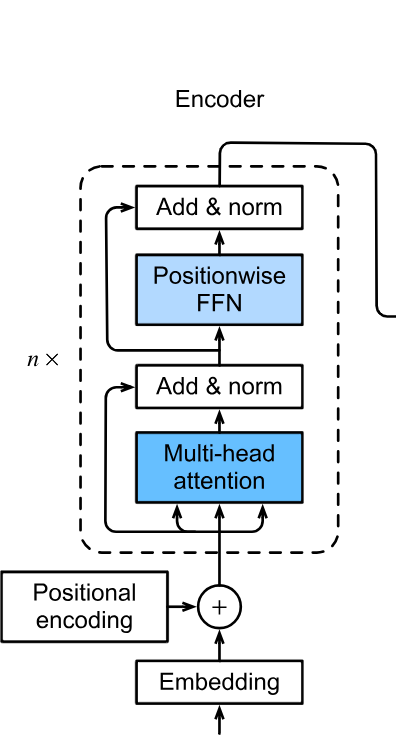

## Transformer Encoder

In [ ]:
class EncoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        # @TODO: fill in the blanks appropriately (given the modules above)
        self.mha        = MultiHeadAttention(n_head = num_heads, d_model = d_model, dropout = dropout)
        self.ffn        = FeedForward(d_model = d_model, d_ff = d_ff, dropout = dropout)

        self.layernorm1 = torch.nn.LayerNorm(d_model)
        self.layernorm2 = torch.nn.LayerNorm(d_model)
        self.dropout1   = torch.nn.Dropout(dropout)
        self.dropout2   = torch.nn.Dropout(dropout)

    def forward(self, inp):

        # Multi-Head Attention
        #   (1) perform Multi-Head Attention on inp
        ''' TODO '''
        mha_output, mha_weights = self.mha(inp, inp, inp)
        # Skip (Residual) Connection
        #   (1) perform dropout
        #   (2) add the input as a skip connection
        ''' TODO '''
        mha_output = self.dropout1(mha_output)
        mha_output = mha_output + inp
        # Layer Normalization
        #   (1) call layernorm on this resulting value
        ''' TODO '''
        mha_output = self.layernorm1(mha_output)
        # Feed Forward Network
        #   (1) apply feed forward layer
        ''' TODO '''
        ffn_output = self.ffn(mha_output)
        # Skip (Residual) Connection
        #   (1) perform dropout
        #   (2) add the output of the first layernorm as a skip connection
        ''' TODO '''
        ffn_output = self.dropout2(ffn_output)
        ffn_output += mha_output
        # Layer Normalization
        #   (1) call layernorm on this resulting value
        ''' TODO '''
        ffn_output = self.layernorm2(ffn_output)
        return ffn_output

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self, input_dim, num_layers, d_model, num_heads, d_ff, dropout=0.1):
        super(Encoder, self).__init__()

        # @TODO: fill in the blanks appropriately (given the modules above and P1 setup)
        self.embedding      = CNN_LSTM_Encoder(input_dim, 256, enc_dropout = dropout)
        self.projection     = torch.nn.Linear(config['d_model']*2, config['d_model'])
        self.pos_encoding   = PositionalEncoding(d_model)

        # concatenating all num_layers EncoderLayer blocks
        self.enc_layers     = torch.nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.dropout        = torch.nn.Dropout(dropout)
        self.layernorm      = torch.nn.LayerNorm(d_model)

    def forward(self, x, input_lengths):

        # apply the CNN-LSTM Encoder (embedding)
        ''' TODO '''
        enc_output, enc_lens = self.embedding(x, input_lengths)
        # adding projection layer to change dimension of encoder_outputs to match d_model
        ''' TODO '''
        x = self.projection(enc_output)
        # apply Positional Encoding on these extracted features
        ''' TODO '''
        x = self.pos_encoding(x)
        # apply dropout as regularization technique
        ''' TODO '''
        x = self.dropout(x)
        # passing inputs through Transformer Encoder blocks
        ''' TODO '''
        for layer in self.enc_layers:
          x = layer(x)

        return x, enc_lens

In [ ]:
class FullTransformer(torch.nn.Module):
    def __init__(self, input_dim, enc_num_layers, dec_num_layers, enc_num_heads, dec_num_heads,
                 d_model, d_ff, target_vocab_size, eos_token, sos_token,
                 pad_token, dropout=0.1, trans_max_seq_length=550, mfcc_max_seq_length=3260):

        super(FullTransformer, self).__init__()

        self.encoder = Encoder(input_dim, enc_num_layers, d_model, enc_num_heads, d_ff, dropout)

        self.decoder = Decoder(dec_num_layers, d_model, dec_num_heads, d_ff,
                               dropout, target_vocab_size, trans_max_seq_length, eos_token, sos_token, pad_token)

    def forward(self, padded_input, input_lengths, padded_target, target_lengths):
        # passing through Encoder
        encoder_output, encoder_lens = self.encoder(padded_input, input_lengths)

        # passing Encoder output and Attention masks through Decoder
        output, attention_weights = self.decoder(padded_target, encoder_output, encoder_lens)

        return output, attention_weights

    def recognize(self, inp, inp_len):
        """ sequence-to-sequence greedy search -- decoding one utterance at a time """

        encoder_outputs, encoder_lens = self.encoder(inp, inp_len)
        out = self.decoder.recognize_greedy_search(encoder_outputs, encoder_lens)

        return out

## Full Model Setup

In [ ]:
full_model = FullTransformer(
input_dim                   = config['input_dim'],
enc_num_layers              = config['enc_num_layers'],
dec_num_layers              = config['dec_num_layers'],
enc_num_heads               = config['enc_num_heads'],
dec_num_heads               = config['dec_num_heads'],

d_model                     = config['d_model'],
d_ff                        = config['d_ff'],

target_vocab_size           = len(VOCAB),
eos_token                   = EOS_TOKEN,
sos_token                   = SOS_TOKEN,
pad_token                   = PAD_TOKEN,

dropout                     = config['enc_dropout'],

# decrease to a small number if you are just trying to implement the network
# we've computed the max length of the transcripts for you
trans_max_seq_length        = 550,
mfcc_max_seq_length         = dataset_max_len).to(device)

In [ ]:
### Load your best P1 model checkpoint
model.load_state_dict(torch.load('/content/checkpoints-basic-transformer/checkpoint-best-loss-model.pth')['model_state_dict'])

<All keys matched successfully>

Freezing model weights except for transformer encoder layers. This is like an initialization strategy so that the encoder learns the range of values required by the decoder. After about 3 epochs when this initialzation is done, unfreeze weights of the entire model and let it train.




In [ ]:
### Copy weights from P1 model to full model
### Freeze the weights of full transformer input embedding, linear projection, and decoder

full_model.encoder.embedding.load_state_dict(model.encoder.state_dict())
for param in full_model.encoder.embedding.parameters():
    param.requires_grad = False # TODO make it non-trainable

full_model.encoder.projection.load_state_dict(model.proj.state_dict())
for param in full_model.encoder.projection.parameters():
    param.requires_grad = False # TODO make it non-trainable

full_model.decoder.load_state_dict(model.decoder.state_dict())
for param in full_model.decoder.parameters():
    param.requires_grad = False # TODO make it non-trainable

## Loss, Optimizer, and Scheduler Definitions

In [ ]:
loss_func   = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN)
scaler      = torch.cuda.amp.GradScaler()

In [ ]:
''' defining optimizer '''

if config["optimizer"] == "SGD":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.SGD(full_model.parameters(),
                              lr=config["learning_rate"],
                              momentum=config["momentum"],
                              weight_decay=1E-4,
                              nesterov=config["nesterov"])

elif config["optimizer"] == "Adam":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.Adam(full_model.parameters(),
                               lr=float(config["learning_rate"]),
                               weight_decay=1e-4)

elif config["optimizer"] == "AdamW":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.AdamW(full_model.parameters(), lr=float(config["learning_rate"]),
                                betas=(0.9, 0.999),
                                eps=1e-9,
                                weight_decay=0.01)

''' defining scheduler '''

if config["scheduler"] == "ReduceLR":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                factor=config["factor"], patience=config["patience"], min_lr=1E-8, verbose=True)

elif config["scheduler"] == "CosineAnnealing":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                T_max = config["epochs"], eta_min=1E-8)

## Experiments

In [ ]:
RESUME_LOGGING = False

In [ ]:
config["epochs"] = 20


Epoch 1/20



Epoch 1/20: 
Train Loss 0.0771	 Train Perplexity 1.0801	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:21<15:14, 21.78s/it, running_distance=16.2344]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEN IN A TRANCE TOO HOLDER'S BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:37<12:29, 18.27s/it, running_distance=11.8594]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:05<15:08, 22.72s/it, running_distance=11.6250]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNEL HE'S OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:37<17:00, 26.16s/it, running_distance=12.6562]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  FEET RANGE WATER LAST LONGER AND ESCAPED MORE AT MORE FROM IN TENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [02:05<17:10, 27.12s/it, running_distance=12.3875]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPIN WITH SUFFICIENT WANDER TO COVERT LETTED ITS TOO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Levenshtein Distance 12.3875
Saved epoch model
Saved best training model

Epoch 2/20



Epoch 2/20: 
Train Loss 0.0749	 Train Perplexity 1.0778	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 3/20



Epoch 3/20: 
Train Loss 0.0729	 Train Perplexity 1.0756	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:29<20:39, 29.52s/it, running_distance=14.7344]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH THAT ENABLES SOMEON IN A TRANCE TO HOLDER'S BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:45<14:38, 21.42s/it, running_distance=11.0078]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORNTS YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:13<16:16, 24.41s/it, running_distance=10.5885]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNEL HIS OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:46<18:12, 28.01s/it, running_distance=12.2070]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  FEET RANGE WATER LAST LONGER AND ESCAPED MORE AT MORE FROM IN TENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [03:07<29:44, 46.95s/it, running_distance=12.3219]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LETTED STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Levenshtein Distance 12.3219
Saved epoch model
Saved best training model

Epoch 4/20



Epoch 4/20: 
Train Loss 0.0711	 Train Perplexity 1.0737	 Learning Rate 0.0001
Epoch 00014: reducing learning rate of group 0 to 9.0000e-05.
Saved epoch model
Saved best training model

Epoch 5/20



Epoch 5/20: 
Train Loss 0.0688	 Train Perplexity 1.0712	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:50<35:20, 50.49s/it, running_distance=15.6562]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLDA'S BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [01:06<20:40, 30.27s/it, running_distance=11.4922]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:34<19:28, 29.21s/it, running_distance=11.0000]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNEL HIS OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:59<17:58, 27.66s/it, running_distance=12.2930]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WHET RANGE WATER LAST LONGER AND ESCAPE MORE AT MORE FROM IN TENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [02:27<17:35, 27.77s/it, running_distance=11.9125]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET ITS TOO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Levenshtein Distance 11.9125
Saved epoch model
Saved best training model

Epoch 6/20



Epoch 6/20: 
Train Loss 0.0672	 Train Perplexity 1.0695	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 7/20



Epoch 7/20: 
Train Loss 0.0658	 Train Perplexity 1.0680	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [01:21<57:20, 81.92s/it, running_distance=17.4844]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLDA'S BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [01:37<29:28, 43.14s/it, running_distance=12.3906]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORNTS YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:02<23:06, 34.66s/it, running_distance=11.6250]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNEL HIS OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [03:21<33:56, 52.22s/it, running_distance=13.7188]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WHET RANGE WATER LAST LONGER AND ESCAPE MORE AT MORE FROM IN TENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [03:53<28:28, 44.95s/it, running_distance=13.2375]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ETTER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LETTED STOO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Levenshtein Distance 13.2375
Saved epoch model
Saved best training model

Epoch 8/20



Epoch 8/20: 
Train Loss 0.0646	 Train Perplexity 1.0668	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 9/20



Epoch 9/20: 
Train Loss 0.0639	 Train Perplexity 1.0660	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [01:21<57:22, 81.95s/it, running_distance=18.0781]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLDOR'S BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [01:37<29:24, 43.04s/it, running_distance=12.7578]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY AND GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:05<24:09, 36.23s/it, running_distance=11.9010]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS EAL OF CAROL EXPOSED HIM TO THE PENEL HIS OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:31<20:44, 31.90s/it, running_distance=12.9141]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WHET RANGE WATER LAST LONGER AND ESCAPE MORE AT MORE FROM IN TENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [03:50<31:01, 48.98s/it, running_distance=12.9437]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET ITS TOO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Levenshtein Distance 12.9437
Saved epoch model
Saved best training model

Epoch 10/20



Epoch 10/20: 
Train Loss 0.0624	 Train Perplexity 1.0644	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 11/20



Epoch 11/20: 
Train Loss 0.0614	 Train Perplexity 1.0633	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:37<26:08, 37.36s/it, running_distance=16.3750]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEON IN A TRANCE TO HOLDA'S BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:53<16:51, 24.66s/it, running_distance=11.8438]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:21<17:35, 26.39s/it, running_distance=11.2604]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS EAL OF CAROL EXPOSED HIM TO THE PENNEL HIS OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:19<25:13, 38.80s/it, running_distance=12.7656]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WHET RANGE WATER LAST LONGER AND ESCAPED MORE AT MORE FROM IN TENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [03:38<33:49, 53.40s/it, running_distance=12.7781]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET ITS DUE GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Levenshtein Distance 12.7781
Epoch 00021: reducing learning rate of group 0 to 8.1000e-05.
Saved epoch model
Saved best training model

Epoch 12/20



Epoch 12/20: 
Train Loss 0.0598	 Train Perplexity 1.0616	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 13/20



Epoch 13/20: 
Train Loss 0.0589	 Train Perplexity 1.0607	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:30<21:08, 30.19s/it, running_distance=15.1094]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEN IN A TRANCE TOOHOLDOW'S BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HAND AND HEELS


Val:   5%|▍         | 2/43 [00:45<14:49, 21.70s/it, running_distance=11.2891]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:13<16:22, 24.56s/it, running_distance=10.8125]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS EAL OF CAROL EXPOSED HIM TO THE PENNEL HIS OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:39<16:19, 25.12s/it, running_distance=12.1289]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WHET RANGE WATER LAST LONGER AND ESCAPE MORE AT MORE FROM IN TENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [02:10<17:13, 27.19s/it, running_distance=12.0062]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LETTEDS TWO GENTLY TILL QUITE DONE WHEN TAKE IT OUD TO COOL


Levenshtein Distance 12.0062
Saved epoch model
Saved best training model

Epoch 14/20



Epoch 14/20: 
Train Loss 0.0580	 Train Perplexity 1.0597	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 15/20



Epoch 15/20: 
Train Loss 0.0571	 Train Perplexity 1.0588	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:31<21:57, 31.37s/it, running_distance=15.1875]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLDOW'S BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:47<15:14, 22.31s/it, running_distance=11.1641]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:15<16:36, 24.90s/it, running_distance=10.6927]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS EAL OF CAROL EXPOSED HIM TO THE PENNEL HIS OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:34<30:10, 46.43s/it, running_distance=12.8008]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WHET RANGE WATER LAST LONGER AND ESCAPE MORE AT MORE FROM IN TENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [03:13<27:39, 43.68s/it, running_distance=12.6937]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET ITS DUE GENTLY TIL QUITE DONE WHEN TAKE IT OUT TO COOL


Levenshtein Distance 12.6937
Saved epoch model
Saved best training model

Epoch 16/20



Epoch 16/20: 
Train Loss 0.0563	 Train Perplexity 1.0579	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 17/20



Epoch 17/20: 
Train Loss 0.0556	 Train Perplexity 1.0572	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:35<24:43, 35.33s/it, running_distance=15.5156]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLDOW'S BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HAND AND HEELS


Val:   5%|▍         | 2/43 [00:51<16:28, 24.10s/it, running_distance=11.3281]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:17<16:40, 25.02s/it, running_distance=10.7812]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS EAL OF CAROL EXPOSED HIM TO THE PENNELT HIS OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:58<20:13, 31.12s/it, running_distance=12.1875]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WHET RANGE WATER LAST LONGER AND ESCAPE MORE AT MORE FROM IN TENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [03:17<30:45, 48.58s/it, running_distance=12.2844]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET ITS TOO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Levenshtein Distance 12.2844
Epoch 00027: reducing learning rate of group 0 to 7.2900e-05.
Saved epoch model
Saved best training model

Epoch 18/20



Epoch 18/20: 
Train Loss 0.0545	 Train Perplexity 1.0560	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 19/20



Epoch 19/20: 
Train Loss 0.0534	 Train Perplexity 1.0549	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [01:21<57:17, 81.85s/it, running_distance=18.5625]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEN IN A TRANCE TOO HOLDA'S BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [01:37<29:27, 43.12s/it, running_distance=12.9531]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:02<23:09, 34.74s/it, running_distance=11.6927]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS EAL OF CAROL EXPOSED HIM TO THE PENDLED HIS OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SICIUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:46<24:57, 38.40s/it, running_distance=13.0352]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WHET RANGE WATER LAST LONGER AND ESCAPE MORE AT MORE FROM IN TENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [03:19<23:04, 36.42s/it, running_distance=12.6875]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET ITS TOO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Levenshtein Distance 12.6875
Saved epoch model
Saved best training model

Epoch 20/20



Epoch 20/20: 
Train Loss 0.0527	 Train Perplexity 1.0541	 Learning Rate 0.0001
Saved epoch model
Saved best training model


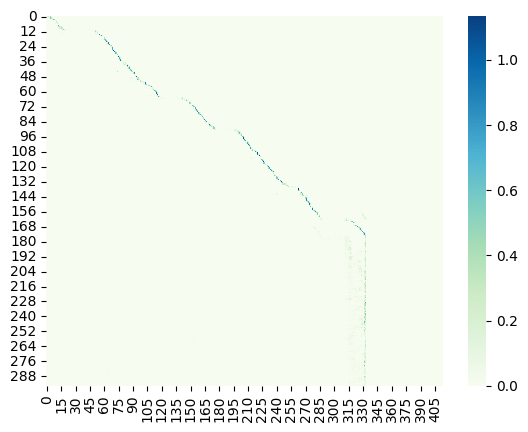

In [ ]:
###  Now let's train the encoder to master the encoder input ranges
e                   = 0
best_loss           = 10.0

checkpoint_root = os.path.join(os.getcwd(), 'checkpointsfull')
os.makedirs(checkpoint_root, exist_ok=True)
wandb.watch(full_model, log="all")

checkpoint_best_loss_model_filename     = 'checkpoint-best-loss-modelfull.pth'
checkpoint_last_epoch_filename          = 'checkpoint-epochfull-'
best_loss_model_path                    = os.path.join(checkpoint_root, checkpoint_best_loss_model_filename)

if RESUME_LOGGING:
    # change if you want to load best test model accordingly
    checkpoint = torch.load(wandb.restore(checkpoint_best_loss_model_filename, run_path=""+run_id).name)

    full_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    e = checkpoint['epoch']

    print("Resuming from epoch {}".format(e+1))
    print("Epochs left: ", config['epochs']-e)
    print("Optimizer: \n", optimizer)

torch.cuda.empty_cache()
gc.collect()

epochs = config["epochs"]
for epoch in range(e, epochs):

    print("\nEpoch {}/{}".format(epoch+1, config["epochs"]))

    curr_lr = float(optimizer.param_groups[0]["lr"])

    train_loss, train_perplexity, attention_weights = train_model(full_model, train_loader, optimizer)

    print("\nEpoch {}/{}: \nTrain Loss {:.04f}\t Train Perplexity {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config["epochs"], train_loss, train_perplexity, curr_lr))

    if (epoch % 2 == 0):    # validate every 2 epochs to speed up training
        levenshtein_distance = validate_fast(full_model, val_loader)
        print("Levenshtein Distance {:.04f}".format(levenshtein_distance))

        wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr,
                "val_distance"      : levenshtein_distance})

    else:
        wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr})

    # plotting the encoder-nearest and decoder-nearest attention weights
    attention_keys = list(attention_weights.keys())

    # plot_attention_weights((attention_weights[attention_keys[0]][0]).cpu().detach().numpy())
    # plot_attention_weights(attention_weights[attention_keys[-1]][0].cpu().detach().numpy())

    attention_weights_decoder_self       = attention_weights[attention_keys[0]][0].cpu().detach().numpy()
    attention_weights_decoder_cross      = attention_weights[attention_keys[-1]][0].cpu().detach().numpy()
    save_attention_plot(attention_weights_decoder_cross, epoch)

    if config["scheduler"] == "ReduceLR":
        scheduler.step(levenshtein_distance)
    else:
        scheduler.step()

    ### Highly Recommended: Save checkpoint in drive and/or wandb if accuracy is better than your current best
    epoch_model_path = os.path.join(checkpoint_root, (checkpoint_last_epoch_filename + str(epoch) + '.pth'))
    save_model(full_model, optimizer, scheduler, ['train_loss', train_loss], epoch, epoch_model_path)
    ## wandb.save(epoch_model_path) ## Can't save on wandb for all epochs, may blow up storage

    print("Saved epoch model")

    # the first time we add the transformer encoder block, we freeze all other weights
    #   except the transformer encoder weights and train this partially-frozen model
    #   for about 3 epochs to weight initialize the transformer encoder weights.
    #   This speeds up convergence of the entire network.
    if epoch == 20:
        break

    if train_loss <= best_loss:
        best_loss = train_loss
        save_model(full_model, optimizer, scheduler, ['train_loss', train_loss], epoch, best_loss_model_path)
        #wandb.save(best_loss_model_path)
        print("Saved best training model")

### Finish your wandb run
# run.finish()

In [ ]:
wandb.save('/content/checkpointsfull/checkpoint-best-loss-modelfull.pth')
wandb.save('/content/checkpoints-basic-transformer/checkpoint-best-loss-model.pth')

['/content/wandb/run-20240426_210613-w12y44i2/files/checkpoints-basic-transformer/checkpoint-best-loss-model.pth']

In [ ]:
checkpoint = torch.load('/content/checkpointsfull/checkpoint-best-loss-modelfull.pth')
full_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
wandb.save('/content/attention_plots.zip')

['/content/wandb/run-20240426_210613-w12y44i2/files/content/attention_plots.zip']

In [ ]:
!zip -r attention_plots.zip cross*

  adding: cross_attention-epoch0.png (deflated 9%)
  adding: cross_attention-epoch100.png (deflated 2%)
  adding: cross_attention-epoch101.png (deflated 2%)
  adding: cross_attention-epoch102.png (deflated 3%)
  adding: cross_attention-epoch103.png (deflated 5%)
  adding: cross_attention-epoch104.png (deflated 6%)
  adding: cross_attention-epoch105.png (deflated 7%)
  adding: cross_attention-epoch106.png (deflated 7%)
  adding: cross_attention-epoch107.png (deflated 7%)
  adding: cross_attention-epoch108.png (deflated 9%)
  adding: cross_attention-epoch109.png (deflated 7%)
  adding: cross_attention-epoch10.png (deflated 8%)
  adding: cross_attention-epoch110.png (deflated 8%)
  adding: cross_attention-epoch111.png (deflated 8%)
  adding: cross_attention-epoch119.png (deflated 9%)
  adding: cross_attention-epoch11.png (deflated 8%)
  adding: cross_attention-epoch120.png (deflated 9%)
  adding: cross_attention-epoch121.png (deflated 8%)
  adding: cross_attention-epoch122.png (deflated 8

In [ ]:
validate_full(full_model, val_loader)

Val:   2%|▏         | 1/43 [00:48<33:43, 48.18s/it, running_distance=16.1250]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLDER'S BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [01:03<19:49, 29.01s/it, running_distance=11.7500]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:31<18:51, 28.30s/it, running_distance=10.8438]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS EAL OF CAROL EXPOSED HIM TO THE PENDLED HIS OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SICIUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:13<21:56, 33.75s/it, running_distance=12.5625]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WHET RANGE WATER LAST LONGER AND ESCAPE MORE AT MORE FROM IN TENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [03:32<31:44, 50.12s/it, running_distance=12.8438]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET ITS TOO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Val:  14%|█▍        | 6/43 [03:57<25:42, 41.69s/it, running_distance=13.0130]


Ground Truth :  I EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALGEBRA ENGLISH AND FRENCH MUSIC HE SNORTS
Prediction   :  EXPLAINED THAT I'M TAKING NUISIC AND ALSO VIOLIGY ALTER ENGLISH IN FRENCH MUSIC THESE NORS


Val:  16%|█▋        | 7/43 [05:17<32:25, 54.04s/it, running_distance=12.8839]


Ground Truth :  FROM UNDER THE LINING HE NOW PRODUCED A COLLECTION OF BRILLIANTLY COLORED PAPER FIGURES SEVERAL INCHES HIGH AND STIFF ENOUGH TO STAND ALONE
Prediction   :  FROM UNDER THE LINING HE NOW PRODUCED A COLLECTION OF BRILLIANTLY COLORED PAPER FIGURES SEVERAL INJUST HIGH AND STIFFING OFF TO STAND ALONE


Val:  19%|█▊        | 8/43 [05:40<25:43, 44.10s/it, running_distance=12.1719]


Ground Truth :  NOW HIS MIDDLE HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO
Prediction   :  NOW HIS MILL HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO


Val:  21%|██        | 9/43 [06:15<23:31, 41.53s/it, running_distance=12.7274]


Ground Truth :  HE SAYS THAT BY CUTTING THROUGH FOUR OR FIVE SLICES AT A TIME ALL THE BUTTER IS SQUEEZED OUT OF THE UPPER ONES WHILE THE BOTTOM ONE IS SWIMMING IN FAT LIQUID
Prediction   :  HE SAYS THAT BY CUTTING THROUGH FOUR FIVE SLICES AT A TIME ALL THE BUTTER IS SQUEEZED OUT OF THE UPPER ONES WHILE THE BOTTOM LONEYS SWIMMING IN FAT LEQUID


Val:  23%|██▎       | 10/43 [07:31<28:41, 52.16s/it, running_distance=12.9172]


Ground Truth :  OH REJOINED THE DAGUERREOTYPIST BECAUSE LIKE AN OLD LADY'S CUP OF TEA IT IS WATER BEWITCHED
Prediction   :  OH REJOINED IT TO GARA TYPEST BECAUSE LIKE AN OLD LADIES CUP OF TIGUE IT IS WATER BEWITCHED


Val:  26%|██▌       | 11/43 [07:50<22:23, 42.00s/it, running_distance=12.2784]


Ground Truth :  BY THE TIME HE REACHED HIS OWN STREET HE WAS KEENLY ALIVE TO THE DIFFICULTIES OF HIS SITUATION AND WISHED OVER AND OVER THAT SOME SOLUTION WOULD OFFER ITSELF THAT HE COULD SEE HIS WAY OUT
Prediction   :  BY THE TIME HE REACHED HIS OWNSTRET HE WAS KEENLY ALIVE TO THE DIFFICULTIES OF HIS SITUATION AND WISHED OVER AND OVER THAT SOME SOLUTION WOULD OFFER IN THESELF THAT HE COULD SEE HIS WAY OUT


Val:  28%|██▊       | 12/43 [08:29<21:13, 41.08s/it, running_distance=12.2721]


Ground Truth :  I WAS TO SEE THE SHEEP NOT NECESSARILY CLOSE AT HAND NOR TO GET THEM IN A SINGLE MOB BUT TO SEE ENOUGH OF THEM HERE AND THERE TO FEEL EASY THAT NOTHING HAD GONE WRONG THIS WAS NO DIFFICULT MATTER FOR THERE WERE NOT ABOVE EIGHT HUNDRED OF THEM AND BEING ALL BREEDING EWES THEY WERE PRETTY QUIET
Prediction   :  I WAS TO SEE THE SHEEP NOT THIS AS AIRLY CLOSE AT HAND OR TO GET THEM IN A SINGLE MOB BUT TO SEENOUGH OF THEM HERE AND THERE TO FEEL EASY THAT NOTHING HAD GONE WRONG THIS WAS NO DIFFICULT MATTER FOR THERE WERE NOT EM OF EIGHT HUNDRED OF THEM AND BEING ALL BREATING YOUSE THEY WERE PRETTY QUIET


Val:  30%|███       | 13/43 [08:53<17:50, 35.67s/it, running_distance=12.1214]


Ground Truth :  THERE APPEARED TO BE NO KNOCKER THOUGH WHETHER IT HAD BEEN TWISTED OFF WAS MORE THAN I COULD SAY
Prediction   :  THEY APPEARED TO BE NO KNOCKER THOUGH WHETHER IT HAD BEEN TWISTED OFF WAS MORE THAN I COULD SAY


Val:  33%|███▎      | 14/43 [09:10<14:36, 30.23s/it, running_distance=11.6417]


Ground Truth :  THIS MAN WAS CLAD IN A BROWN CAMEL HAIR ROBE AND SANDALS AND A GREEN TURBAN WAS ON HIS HEAD
Prediction   :  THIS MAN WAS CLAD IN A BROWN CABBLED HERE ROBE AND SANDLES AND A GREEN TURBIT WAS ON HIS HEAD


Val:  35%|███▍      | 15/43 [10:27<20:40, 44.30s/it, running_distance=11.6010]


Ground Truth :  HE SMILED GUILTILY AS HE ADDED BUT I MUST ADMIT I WAS MORE THAN A LITTLE CONCERNED MYSELF
Prediction   :  HE SMILED GUILTILY AS HE ADDED BUD I MUST ADMIT I WAS MORE THAN A LITTLE CONCERNED MYSELF


Val:  37%|███▋      | 16/43 [11:44<24:18, 54.02s/it, running_distance=12.1211]


Ground Truth :  NOT BE IT EVER REMEMBERED THAT THE SLIGHTEST SUSPICION OF IMMORALITY ATTACHES EITHER TO THE HEROINE OF THIS BOOK OR TO THE LEADING PHILOSOPHERS OF HER SCHOOL FOR SEVERAL CENTURIES
Prediction   :  NOT BE IT EVER REMEMBERED THAT THE SLIGHTES SUSPICION OF THE MORALITY ATTACHED HIS ZOY EITHER TO THE HAIR ONE AT THIS BOOK OR TO THE LEADING FILOSS OF HER SEVERSCHOOL FOR SEVERAL CENTURIES


Val:  40%|███▉      | 17/43 [13:09<27:28, 63.39s/it, running_distance=13.3529]


Ground Truth :  BUT NEITHER THE GLORIFIED WOODS ON THE ONE HAND NOR THE LAKE ON THE OTHER COULD AT FIRST HOLD THE EYE
Prediction   :  BUT NEITHER THE GLORIFIED WOODS ON THE ONE HAND NOR THE LAKE ON THE OTHER COULD AT FIRST COLD THE EYE


Val:  42%|████▏     | 18/43 [14:30<28:36, 68.67s/it, running_distance=13.3637]


Ground Truth :  THIS SWEETWATER AS THEY CALLED HIM WAS I HAVE SINCE UNDERSTOOD ONE OF HIS PROTEGES AND MORE OR LESS OF A FAVOURITE
Prediction   :  THIS SWEETWATER AS THEY CALLED HIM WAS I HAVE SENS UNDERSTOOD ONE OF HE IS PROTA JASE AND MORE OR LESS OF A FAVORITE


Val:  44%|████▍     | 19/43 [15:04<23:21, 58.40s/it, running_distance=13.3413]


Ground Truth :  I PICKED IT UP AND COMING UP TO HIM JUST AS HE WAS GOING DOWN THE STEPS I HANDED IT TO HIM
Prediction   :  I PICKED IT UP AND COMING UP TO HIM JUST AS HE WAS GOING DOWN THE STEPS I HANDLED TO HIM


Val:  47%|████▋     | 20/43 [15:32<18:52, 49.24s/it, running_distance=13.1859]


Ground Truth :  IN MAKING THIS HE HAD EXPECTED NO SUCCESS THOUGH FROM THE ENERGETIC NATURE OF HIS DISPOSITION HE HAD MADE THE ATTEMPT WITH SOME ZEAL
Prediction   :  IN MAKING THIS HE HAD EXPECTED NO SUCCESS THOUGH FROM THE ENERGETIC NATURE OF HIS DISPOSITION HE HAD MADE THE ATTACT WITH SOMESEAL


Val:  49%|████▉     | 21/43 [16:05<16:16, 44.39s/it, running_distance=13.3847]


Ground Truth :  WHAT LED ME INTO IT WAS A CERTAIN THIRST FOR VENGEANCE WHICH IS STRONG ENOUGH TO DISTURB THE QUIETEST HEARTS
Prediction   :  WHAT LED ME INTO IT WAS A CERTAIN THIRST FOR VENGEANCE WHICH IS STRONG ENOUGH TO DISTURB THE QUIETEST HEARTS


Val:  51%|█████     | 22/43 [17:19<18:34, 53.08s/it, running_distance=13.2500]


Ground Truth :  OUR ROADS LIE TOGETHER DOCTOR
Prediction   :  OUR ROADS LIE TOGETHERED AFTER


Val:  53%|█████▎    | 23/43 [17:36<14:09, 42.50s/it, running_distance=13.0217]


Ground Truth :  HE'S A KIND NEIGHBORLY MAN AND HIS BOY WILL TAKE MY PLACE ABOUT THE HOUSE AND PROTECT YOU FAITHFULLY
Prediction   :  HE SACHINGE NEIGHBORLY MAN AND TO SPOYO WILL TAKE MY PLACE ABEL THE HOUSE AND PROTECTIO FAITHFULLY


Val:  56%|█████▌    | 24/43 [19:02<17:31, 55.33s/it, running_distance=13.6960]


Ground Truth :  OCCASIONALLY TOO THE WAKING CALL COMES TOO LATE THE CHANCE WHICH GIVES PERMISSION TO TAKE ACTION WHEN THEIR BEST YOUTH AND STRENGTH FOR ACTION HAVE BEEN USED UP IN SITTING STILL AND HOW MANY A ONE JUST AS HE SPRANG UP HAS FOUND WITH HORROR THAT HIS LIMBS ARE BENUMBED AND HIS SPIRITS ARE NOW TOO HEAVY
Prediction   :  OCCASIONALLY TOO THE WAKING CALL COMES TOO LATE THE CHANCE WHICH GIS PERMISSION TO TAKE ACTION WITH THEIR BEST YOUTH AND STRENGTH FORACTION HAVE BEEN USED UP IN THE SITTING STILL AND HOW MANY A WONGEST AS HE SPRANG UP HIS FOUND WITH HORROR THAT HIS LIMBS ARE NOW TWO HEAVY


Val:  58%|█████▊    | 25/43 [19:39<14:59, 49.98s/it, running_distance=13.7863]


Ground Truth :  YOU ARE NOT LIKE MY PEOPLE THE PINKIES AND THERE IS NO PLACE FOR YOU IN OUR COUNTRY
Prediction   :  YOU ARE NOT LIGHT MY PEOPLE THE PINKEYS AND THERE IS NO PLACE FOR YOU IN OUR HUNTRY


Val:  60%|██████    | 26/43 [20:10<12:31, 44.22s/it, running_distance=13.8978]


Ground Truth :  THIS WAS THE FIRST BIG BATTLE IN WHICH OUR REGIMENT HAD EVER BEEN ENGAGED
Prediction   :  THIS WAS THE FIRST BIG BATTLEN WHICH OUR REGIMENT ADEVERBEN ENGAGED


Val:  63%|██████▎   | 27/43 [20:36<10:17, 38.62s/it, running_distance=13.7922]


Ground Truth :  A MAN IN THE WELL
Prediction   :  THE MAN ON THE WELL


Val:  65%|██████▌   | 28/43 [20:51<07:53, 31.59s/it, running_distance=13.5463]


Ground Truth :  IT WAS ESTABLISHED AT SOUTHWARK
Prediction   :  IT WAS ESTABLISHED HIS SOUTHWORK


Val:  67%|██████▋   | 29/43 [21:11<06:35, 28.25s/it, running_distance=13.2893]


Ground Truth :  OUR TWO HORSES WITH THE LUGGAGE FOLLOWED OF THEIR OWN ACCORD WITHOUT REQUIRING WHIP OR SPUR
Prediction   :  ARE TWO HORSES WITH THE LUGGAGE FALLEN OF THEIR OWN ACCORD WITHOUT REQUIRING WITH OR SPUR


Val:  70%|██████▉   | 30/43 [21:39<06:03, 27.98s/it, running_distance=13.2255]


Ground Truth :  WE NEED KENTUCKY AND I UNDERSTAND THAT A VERY LITTLE MORE MAY BRING THE STATE TO US GO WITH YOUR FATHER I UNDERSTAND THAT YOU HAVE BEEN A BRAVE YOUNG SOLDIER HERE AND MAY YOU DO AS WELL UP THERE
Prediction   :  WE NED CONTUCKING I UNDERSTAND THAT A VERY LITTLE MORE MAY BRING THE STATY TO US GO WITH YOUR FATHER I UNDERSTAND THAT YOU HAVE BEEN A BRAVE YOUNG SOLDIER HERE AND MAY YOU DO AS WELL UP THERE


Val:  72%|███████▏  | 31/43 [21:54<04:49, 24.12s/it, running_distance=13.0524]


Ground Truth :  NO I AM THE LIGHTER OF THE TWO URGED TAD
Prediction   :  NO I AM THE LIGHTER OF THE TWO EARGED HAD


Val:  74%|███████▍  | 32/43 [22:11<04:04, 22.18s/it, running_distance=13.1479]


Ground Truth :  NONE OF YOU WILL BE FIT FOR DUTY TO MORROW
Prediction   :  NOT A VIEW WILL BE FIT FOR DUTAGE MORROW


Val:  77%|███████▋  | 33/43 [22:32<03:38, 21.81s/it, running_distance=13.1018]


Ground Truth :  NOW FIFTEEN YEARS AFTER THE PRINCESS WAS BORN SHE WAS WITH THE KING AND QUEEN AT ONE OF THEIR CASTLES AND AS SHE WAS RUNNING ABOUT BY HERSELF SHE CAME TO A LITTLE CHAMBER AT THE TOP OF A TOWER AND THERE SAT AN HONEST OLD WOMAN SPINNING FOR SHE HAD NEVER HEARD OF THE KING'S EDICT
Prediction   :  NOW FIFTEEN YEARS AFTER THE PRINCESS WAS BORN SHE WAS WITH THE KING AND QUEEN ONE OF THEIR CASTLES AND AS SHE WAS RUNNING ABOUT BY HERSELF SHE CAME TO A LITTLE CHAMBER AT THE TOP OF A TOWER AND THERE SAD AND HONESTOLD WOMAN SPINNING BUT SHE HAD NEVER HEARD OF THE KING'S EDIC


Val:  79%|███████▉  | 34/43 [23:47<05:39, 37.70s/it, running_distance=13.0349]


Ground Truth :  AND HE STRODE DOWN BETWEEN THE MARBLE TABLES AND OUT BY THE SWING DOOR IT WAS A VERY GOOD EXIT
Prediction   :  AND HE STROMED DOWN BETWEEN THE MARBLE TABLES AND OUT BY THE SWINGDOOR IT WAS A VERY GOOD EX IT


Val:  81%|████████▏ | 35/43 [24:18<04:45, 35.71s/it, running_distance=13.0621]


Ground Truth :  IN THIS SAME DISTRICT IS THE MINT IN COMMERCIAL STREET BETWEEN MONTGOMERY AND KEARNY STREETS
Prediction   :  IN THE SAME DISTRICT IS THE MINT IN COMMERCIAL STREET BETWEEN MUT GOMERIAN CARNEY STREETS


Val:  84%|████████▎ | 36/43 [24:32<03:24, 29.24s/it, running_distance=13.1306]


Ground Truth :  HIS OWN SKIN HAD SIZZLED UNDER THE RED HOT BRAND HE MURMURED SOFTLY
Prediction   :  HIS OWN SKIN HAD SIZZLED UT HIS RED HOT GRANTEMARID SOFTLY


Val:  86%|████████▌ | 37/43 [24:54<02:41, 26.91s/it, running_distance=13.1436]


Ground Truth :  HIS SUCCESS SEEMS TO HAVE BEEN THE OUTGROWTH OF HARD STUDY AND ABILITY TO PERFORM THE MOST EXHAUSTIVE LABOR WITHOUT FATIGUE
Prediction   :  HIS SUCCESS SEEMS TO HAVE BEEN THE OUTGROWTH OF HARD STUDY AND ABILITY TO PERFORM THE MOST EXHAUSTIVE LABOUR WITHOUT FATEE


Val:  88%|████████▊ | 38/43 [25:28<02:25, 29.13s/it, running_distance=13.1040]


Ground Truth :  MY OWN REGIMENT WAS IN THE ADVANCE
Prediction   :  MY UNE REGIMENT WAS IN THE ADVANCE


Val:  91%|█████████ | 39/43 [25:44<01:41, 25.30s/it, running_distance=13.0112]


Ground Truth :  WE ARE GOING INTO THE FOREST TO HEW WOOD AND IN THE EVENING WHEN WE ARE READY WE WILL COME AND FETCH YOU AGAIN
Prediction   :  WE ARE GOING INTO THE FOREST TO HUE WOULD AND AN EVENING ONE WARE READY WE'LL COME IN FECTUE AGAIN


Val:  93%|█████████▎| 40/43 [26:04<01:10, 23.59s/it, running_distance=12.8555]


Ground Truth :  SHE ASKED DIRECTLY IF HER FATHER WAS DEAD
Prediction   :  SHE ASKED DIRECTLY IF HER FATHER WAS DEAD


Val:  95%|█████████▌| 41/43 [26:26<00:45, 22.96s/it, running_distance=12.7435]


Ground Truth :  NOW HELICON MUST NEEDS POUR FORTH FOR ME AND WITH HER CHOIR URANIA MUST ASSIST ME TO PUT IN VERSE THINGS DIFFICULT TO THINK
Prediction   :  NOW HELECON MUST NEEDS POOR FORTH FOR ME AND WITH HER QUIRE YOUROUNNIE A MUST ASSIST ME TO PUT INVERSE THINGS DIFFICULT TO THINK


Val:  98%|█████████▊| 42/43 [26:56<00:25, 25.23s/it, running_distance=12.7381]


Ground Truth :  AND IN HIS SPEECH HE LAUGH'D AND LAUGH'D AGAIN THEN WHILE IT WAS HIS PLEASURE TO REMAIN I CHANCED TO LOOK THE WAY HE HAD DRAWN NEAR AND SAW THE LADIES JOAN AND BEATRICE APPROACH ME THIS THE OTHER FOLLOWING ONE AND A SECOND MARVEL INSTANTLY
Prediction   :  IT IN HIS SPEP HE LAUGHED AND MAT AGAIN THEN WHILE IT WAS HIS PLEASURED REMAIN I CHANCED TO LOOK THE WAY HE HAD DRAWNG MERE AND SAW THE LADIES JONE OF BEATRESS APPROACH ME THIS THE OTHER FOLLOWING ONE AND A SECOND MARBLE INSTANTLY


Val: 100%|██████████| 43/43 [27:07<00:00, 21.08s/it, running_distance=12.9907]


Ground Truth :  THOU LIKE ARCTURUS STEADFAST IN THE SKIES WITH TARDY SENSE GUIDEST THY KINGDOM FAIR BEARING ALONE THE LOAD OF LIBERTY
Prediction   :  THOU LIKE ARTEROUS STEADFAST IN A SKIES WITH TARTY SENSE GUIDEST BY KINGDOM FAIR BEARING ALONE THE LOAD OF LIBERTY


12.990697674418605

In [ ]:
### TODO Unfreeze the weights of full transformer input embedding and decoder
# @NOTE: after unfreezing, continue training the P2 model for more epochs to achieve best results!

for param in full_model.encoder.embedding.parameters():
    param.requires_grad = True # TODO make it trainable

for param in full_model.encoder.projection.parameters():
    param.requires_grad = True # TODO make it trainable

for param in full_model.decoder.parameters():
    param.requires_grad = True # TODO make it trainable

## Testing

In [ ]:
full_model.eval()

# progress bar
batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc="Test", ncols=5)

all_predictions = []

for i, data in enumerate(test_loader):
    inputs, inputs_lengths = data
    inputs                 = inputs.to(device)

    with torch.inference_mode():
        greedy_predictions = full_model.recognize(inputs, inputs_lengths)

    greedy_predictions = greedy_predictions.detach().cpu().numpy()

    for batch_idx in range(greedy_predictions.shape[0]):
        pred_sliced = indices_to_chars(greedy_predictions[batch_idx], vocab= VOCAB)
        pred_string = ''.join(pred_sliced)
        all_predictions.append(pred_string)

    batch_bar.update()

Test: 100%|██████████| 41/41 [26:18<00:00, 48.70s/it]

In [ ]:
%cd /content/
df = pd.DataFrame({
    "index" : list(range(len(all_predictions))),
    "label" : all_predictions
})

df.to_csv("improved.csv", index=False)

/content


In [ ]:
!kaggle competitions submit -c automatic-speech-recognition -f improved.csv -m "It's been a ride :)"

100% 287k/287k [00:00<00:00, 639kB/s]
Successfully submitted to Automatic Speech Recognition HW4P2 Slack